# Training a model

In [3]:
import pandas as pd
import gensim
import os
import numpy as np
from importlib import reload

import sys
sys.path.append('../src')
from interventions_labeling_lib import intervention_labeling
from interventions_labeling_lib.intervention_labels import InterventionLabels
from utilities import excel_reader, excel_writer
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
interventions_df = pd.read_excel('../data/hyponyms_for_train.xlsx').fillna("")
interventions_df = shuffle(interventions_df)
test_data = excel_reader.ExcelReader().read_df_from_excel("../data/hyponyms_test_with_predicted_labels_old.xlsx")
test_data = test_data.drop("Predicted Label", axis=1)

for i in range(len(interventions_df)):
    interventions_df["Label"].values[i] = InterventionLabels.INTERVENTION_LABEL_TO_NUMBER[interventions_df["Label"].values[i]]

for i in range(len(test_data)):
    test_data["Label"].values[i] = InterventionLabels.INTERVENTION_LABEL_TO_NUMBER[test_data["Label"].values[i]]

In [3]:
print(interventions_df["Label"].value_counts())
print(test_data["Label"].value_counts())

6    1215
1     972
2     525
3     211
5     170
4     161
Name: Label, dtype: int64
1    155
6    153
2     51
5     31
3     31
4     29
Name: Label, dtype: int64


In [2]:
from sklearn.model_selection import train_test_split

def get_train_and_test_data_splitted(all_dataset = True, test_size=0.1):
    if all_dataset:
        train_data = interventions_df.values
        test_data = interventions_df.values
    else:
        train_data_x, test_data_x,train_y,test_y = train_test_split([data[:-1] for data in interventions_df.values], [data[-1] for data in interventions_df.values], test_size=test_size)
        train_data = np.concatenate((train_data_x,[[val]for val in train_y]),axis=1)
        test_data = np.concatenate((test_data_x,[[val] for val in test_y]),axis=1)
    return train_data, test_data

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

y_train = np.asarray(interventions_df["Label"].values, dtype=int)
y_train_array = np.asarray(interventions_df["Label"].values, dtype=int)
x_train = interventions_df.drop(["Label"], axis=1).values
skfolds = StratifiedKFold(n_splits=5, random_state=42)
scores = []
ind = 0
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_retrained_new")
for train_index, test_index in skfolds.split(x_train, y_train):
    print("Started %d cv block processing"%ind)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_array[train_index]
    x_test_folds = x_train[test_index]
    y_test_folds = y_train_array[test_index]
    train_fold = np.concatenate([x_train_folds, np.reshape(y_train_folds, (-1,1))], axis=1)
    test_fold = np.concatenate([x_test_folds, np.reshape(y_test_folds, (-1,1))], axis=1)
    intervention_labeler.train_model(train_fold, test_fold)
    results = intervention_labeler.predict_class(test_fold)
    scores.append(f1_score(y_test_folds, results, average="macro"))
    ind += 1

In [5]:
from importlib import reload
intervention_labeling = reload(intervention_labeling)

In [6]:
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_retrained_new")
intervention_labeler.train_model(interventions_df.values,test_data.values)

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Google word2vec loaded
Fast text loaded
Phrases loaded
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.63008385 0.65309165 0.71633616 0.6333721  0.67857663 0.65170088
 0.72595325 0.74443845 0.70871682 0.67493167]
Cross validation score(F1): 0.681720
Test accuracy : 0.755556
[[ 99   1   1   1   3  50]
 [  0  35   0   1   0  15]
 [  5   0  23   0   0   3]
 [  0   0   0  28   0   1]
 [  1   0   0   0  25   5]
 [ 19   1   0   0   3 130]]
              precision    recall  f1-score   support

           1       0.80      0.64      0.71       155
           2       0.95      0.69      0.80        51
           3       0.96      0.74      0.84        31
           4       0.93      0.97      0.95        29
           5       0.81      0.81      0.81        31
           6       0.64      0.85      0.73       153

   micro avg       0.76      0.76      0.76       450
   macro avg       0.85      0.78      0.80       450
weighted avg       0.78      0.76      0.76       450

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.57626958 0.62626419 0.67840176 0.59829186 0.65508076 0.68115808
 0.69673641 0.7249687  0.68039975 0.67891361]
Cross validation score(F1): 0.659648
Test accuracy : 0.777778
0.915181315304241
[[109   1   0   1   7  37]
 [  2  35   0   1   0  13]
 [  5   0  22   1   1   2]
 [  2   0   0  26   0   1]
 [  0   0   0   0  26   5]
 [ 19   0   0   0   2 132]]
[[ 841   14    1    3   10  103]
 [  20  444    2    0    1   58]
 [   5    1  196    0    0    9]
 [   0    0    0  152    0    9]
 [   1    0    0    0  161    8]
 [  18    4    1    1    7 1184]]
KNN model hyponym embeddings
Test accuarcy :0.600000
[0.53679413 0.46424432 0.52820144 0.5110896  0.55926071 0.52296969
 0.55204628 0.55955402 0.51350568 0.52463815]
Cross validation score(F1): 0.527230
[[100   2   6   8  10  29]
 [  7  38   1   0   0   5]
 [  6   6  14   1   1   3]
 [  2   0   0  27   0   0]
 [  6   0   0   2  21   2]
 [ 55  10   2   8   8  70]]
Extracting tf features for NMF...
Processed texts 1.419s.
Performed tf-idf vect

../src\text_processing\topic_modeling.py:180: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 55.749s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.7911111111111111
0.952980946527351
[0.95193945 0.95600372 0.95653406 0.94957476 0.95128152 0.9513835
 0.97710216 0.95162223 0.92499297 0.92706611]
Cross validation score(F1): 0.949750
[[136   3   3   0   1  12]
 [  1  46   0   0   0   4]
 [  6   0  25   0   0   0]
 [  5   0   0  21   0   3]
 [  6   0   0   0  21   4]
 [ 40   4   1   0   1 107]]
              precision    recall  f1-score   support

           1       0.70      0.88      0.78       155
           2       0.87      0.90      0.88        51
           3       0.86      0.81      0.83        31
           4       1.00      0.72      0.84        29
           5       0.91      0.68      0.78        31
           6       0.82      0.70      0.76       153

   micro avg       0.79      0.79      0.79       450
   macro avg       0.86      0.78      0.81       450
weighted avg       0.81      0.79      0.79       450



In [7]:
intervention_labeler.save_model("..\\model\\intervention_labels_model_new")

              precision    recall  f1-score   support

           1       0.71      0.98      0.82       140
           2       0.96      0.91      0.93        47
           3       0.92      0.79      0.85        28
           4       1.00      0.92      0.96        24
           5       0.91      0.69      0.78        29
           6       0.92      0.65      0.76       132

   micro avg       0.82      0.82      0.82       400
   macro avg       0.90      0.82      0.85       400
weighted avg       0.85      0.82      0.82       400



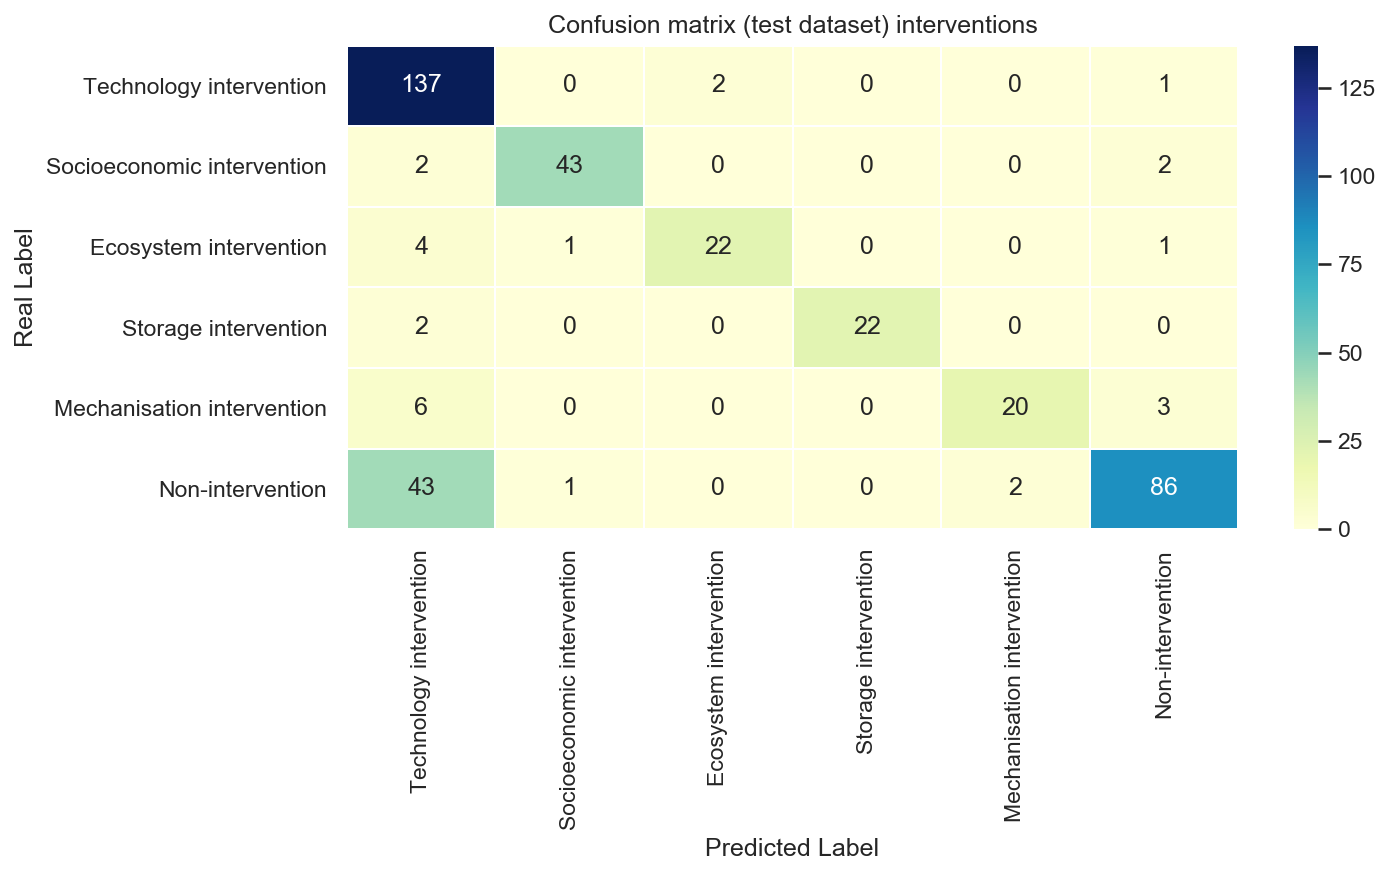

In [10]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pylab as plt
from sklearn.metrics import classification_report, confusion_matrix
from utilities import excel_reader

def get_confusion_matrix(filename):
    df = excel_reader.ExcelReader().read_df_from_excel(filename)
    test_y = [ InterventionLabels.INTERVENTION_LABEL_TO_NUMBER[label] for label in df["Label"].values]
    pred_y = [ InterventionLabels.INTERVENTION_LABEL_TO_NUMBER[label] for label in df["Predicted Label"].values]
    print(classification_report(test_y, pred_y))
    return confusion_matrix(test_y, pred_y)


data_results = [ (get_confusion_matrix("../data/hyponyms_test_with_predicted_labels_old_with_predicted_labels.xlsx"),"Confusion matrix (test dataset) interventions")]

for res in data_results:
    plt.figure(figsize=(10, 6), dpi=150)
    confusion_df = pd.DataFrame(res[0])
    confusion_df.index = InterventionLabels.INTERVENTION_LABEL_TO_NUMBER.keys()
    confusion_df.columns = InterventionLabels.INTERVENTION_LABEL_TO_NUMBER.keys()
    ax = sns.heatmap(confusion_df,annot=True, fmt="d",linewidths=.5,cmap="YlGnBu")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("Real Label")
    ax.set_title(res[1])
    plt.tight_layout()
    #plt.savefig(res[1] + ".png") 
    plt.show()

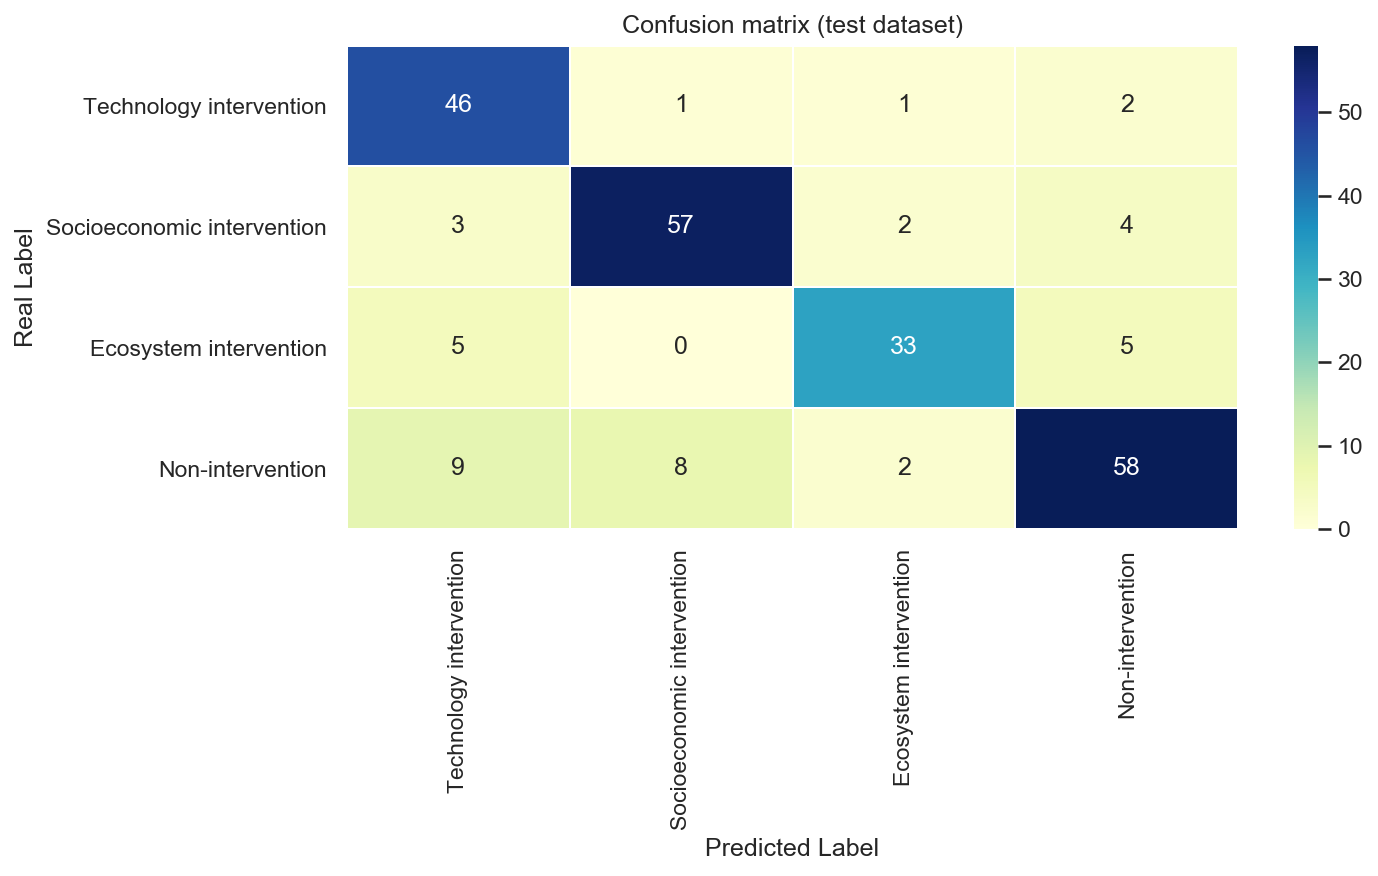

In [22]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pylab as plt
import pandas as pd

data_results = [([[46,  1,  1,  2], 
 [ 3, 57,  2,  4],
 [ 5,  0,  33,  5],
 [ 9,  8,  2, 58]],"Confusion matrix (test dataset)")]

for res in data_results:
    plt.figure(figsize=(10, 6), dpi=150)
    confusion_df = pd.DataFrame(res[0])
    confusion_df.index = ["Technology intervention", "Socioeconomic intervention", "Ecosystem intervention", "Non-intervention"]
    confusion_df.columns = ["Technology intervention", "Socioeconomic intervention", "Ecosystem intervention", "Non-intervention"]
    ax = sns.heatmap(confusion_df,annot=True, fmt="d",linewidths=.5,cmap="YlGnBu")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("Real Label")
    ax.set_title(res[1])
    plt.tight_layout()
    plt.savefig(res[1] + "_interv.png")
    plt.show()

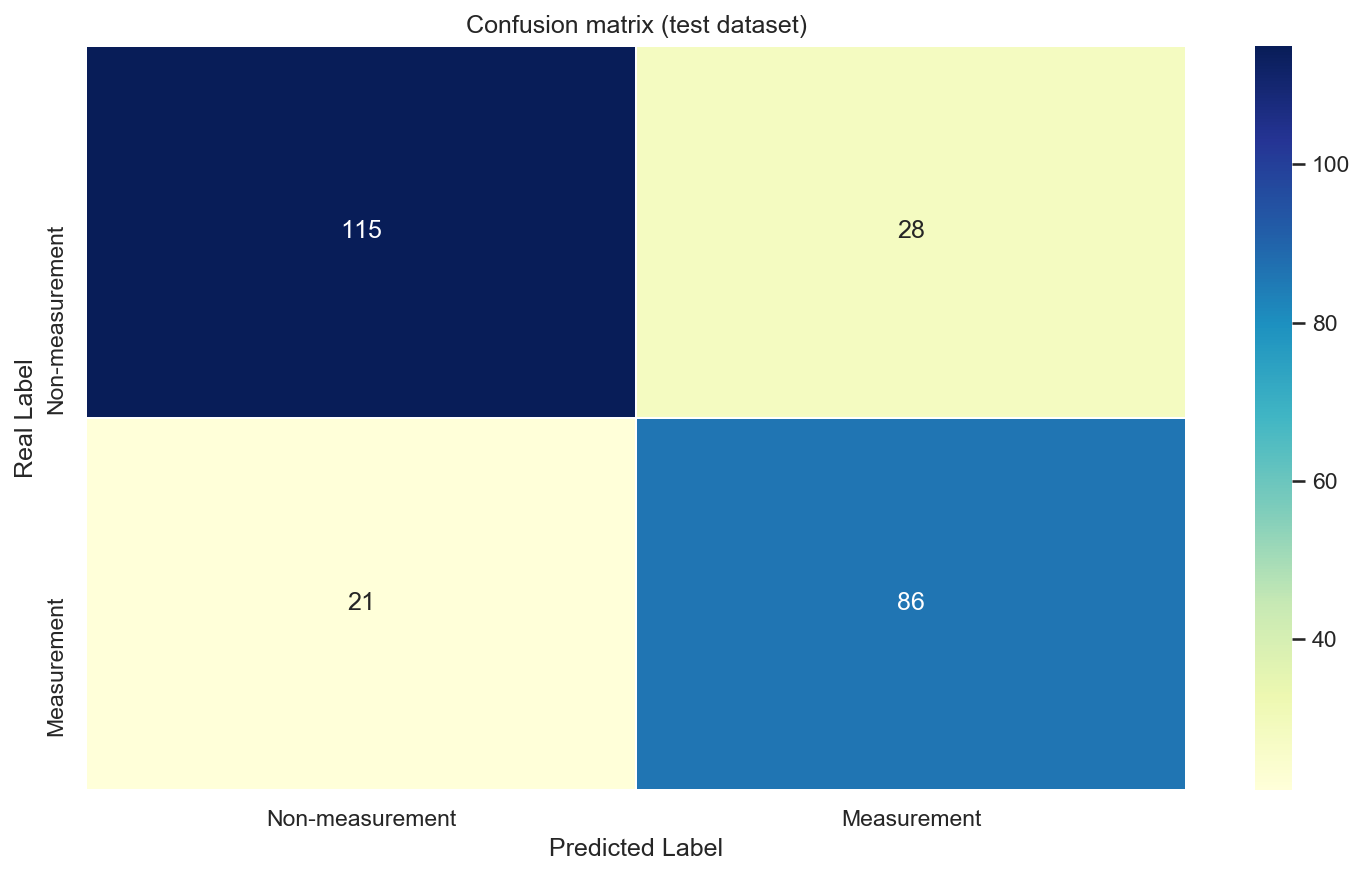

In [4]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pylab as plt
from study_design_type.study_type_labels import StudyTypeLabels

data_results = [([[115, 28],[21, 86]],"Confusion matrix (test dataset)")]

for res in data_results:
    plt.figure(figsize=(10, 6), dpi=150)
    confusion_df = pd.DataFrame(res[0])
    confusion_df.index = ["Non-measurement", "Measurement"]
    confusion_df.columns = ["Non-measurement", "Measurement"]
    ax = sns.heatmap(confusion_df,annot=True, fmt="d",linewidths=.5,cmap="YlGnBu")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("Real Label")
    ax.set_title(res[1])
    plt.tight_layout()
    plt.savefig(res[1] + "_measurements.png")
    plt.show()

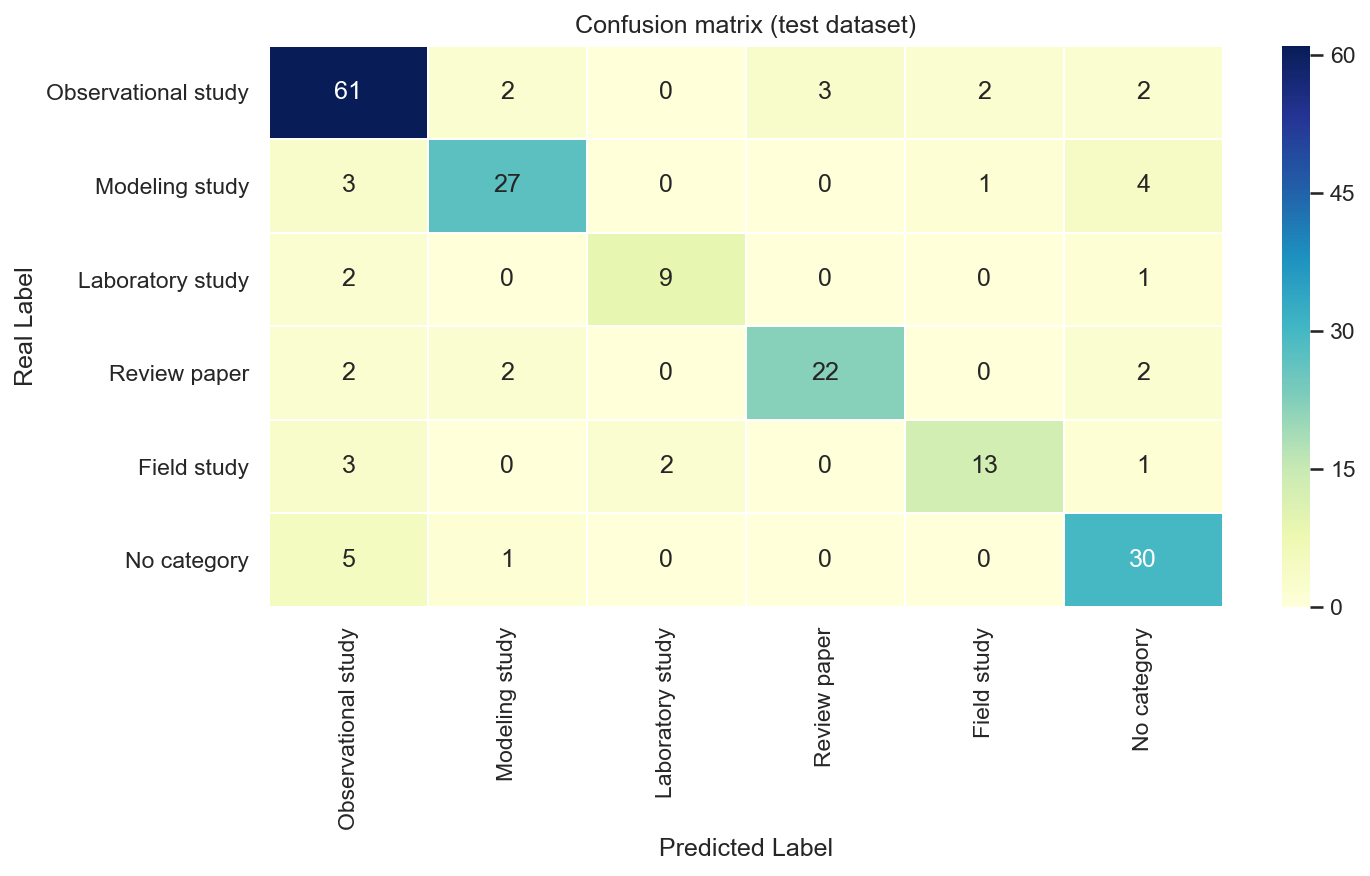

In [5]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pylab as plt
from study_design_type.study_type_labels import StudyTypeLabels

data_results = [([[61, 2, 0,  3,  2, 2],
 [ 3, 27,  0,  0,  1, 4],
 [ 2,  0,  9,  0,  0,  1],
 [ 2,  2,  0, 22,  0, 2],
 [ 3,  0,  2,  0, 13,  1],
 [ 5,  1,  0,  0,  0, 30]],"Confusion matrix (test dataset)")]

for res in data_results:
    plt.figure(figsize=(10, 6), dpi=150)
    confusion_df = pd.DataFrame(res[0])
    confusion_df.index = StudyTypeLabels.STUDY_TYPE_LABEL_TO_NUMBER.keys()
    confusion_df.columns = StudyTypeLabels.STUDY_TYPE_LABEL_TO_NUMBER.keys()
    ax = sns.heatmap(confusion_df,annot=True, fmt="d",linewidths=.5,cmap="YlGnBu")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("Real Label")
    ax.set_title(res[1])
    plt.tight_layout()
    plt.savefig(res[1] + "_study_type.png")
    plt.show()

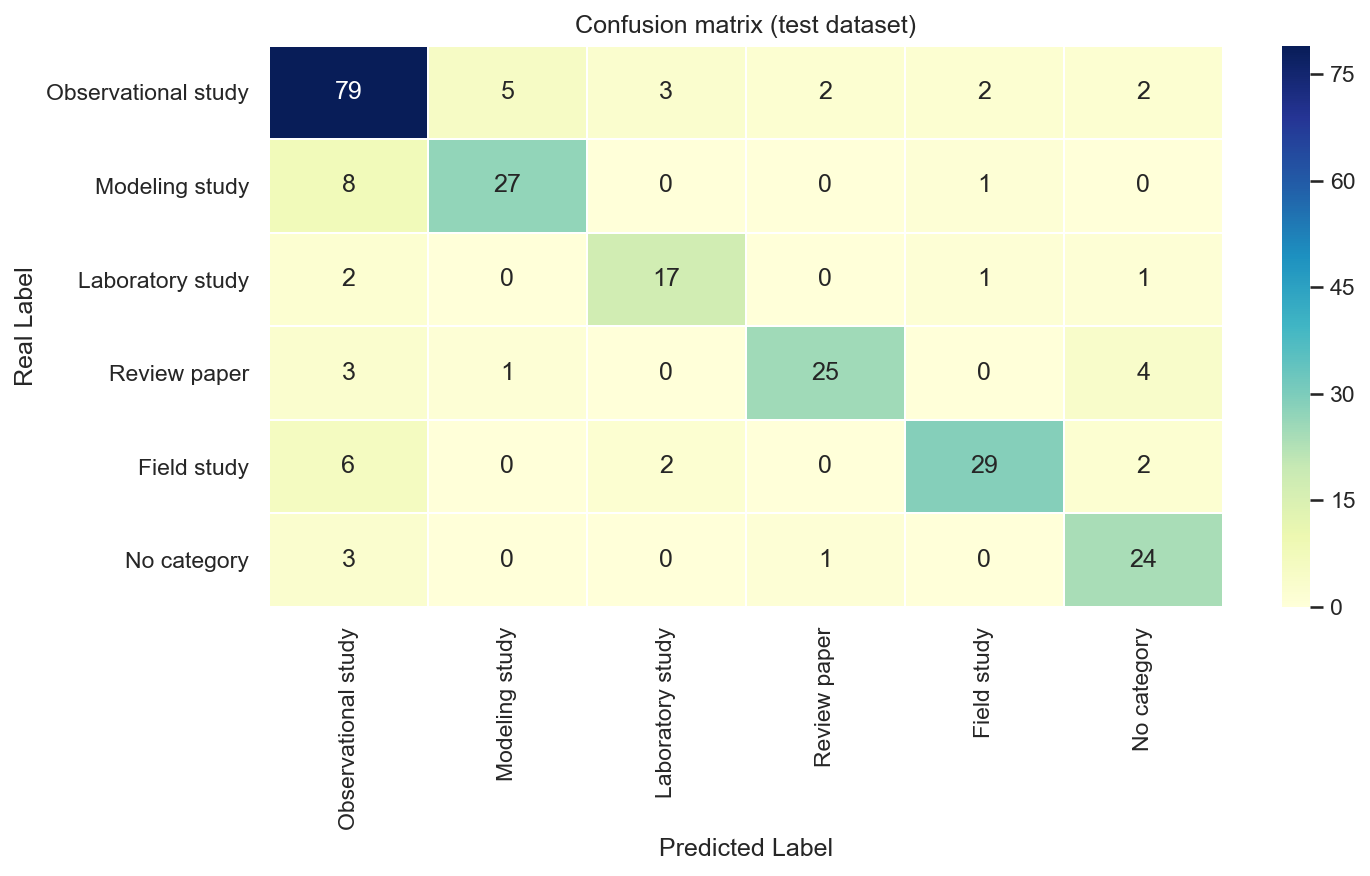

In [3]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pylab as plt
from study_design_type.study_type_labels import StudyTypeLabels

data_results = [([[79,  5,  3,  2,  2,  2],
 [ 8, 27,  0,  0,  1,  0],
 [ 2,  0, 17,  0,  1,  1],
 [ 3,  1,  0, 25,  0, 4],
 [ 6,  0,  2,  0, 29,  2],
 [ 3,  0,  0,  1,  0, 24]],"Confusion matrix (test dataset)")]

for res in data_results:
    plt.figure(figsize=(10, 6), dpi=150)
    confusion_df = pd.DataFrame(res[0])
    confusion_df.index = StudyTypeLabels.STUDY_TYPE_LABEL_TO_NUMBER.keys()
    confusion_df.columns = StudyTypeLabels.STUDY_TYPE_LABEL_TO_NUMBER.keys()
    ax = sns.heatmap(confusion_df,annot=True, fmt="d",linewidths=.5,cmap="YlGnBu")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("Real Label")
    ax.set_title(res[1])
    plt.tight_layout()
    plt.savefig(res[1] + "_study_type.png")
    plt.show()

# USAID water interventions

In [4]:
from sklearn.metrics import f1_score
from text_processing import text_normalizer

def get_f1_score_test_data(test_data, intervention_labeler):
    res_pred, res_prob = intervention_labeler.predict_class(test_data.values, return_probs=True)
    res_true = test_data["Label"].values
    return f1_score(res_true, res_pred, average="macro")

def get_f1_multi_label(test_labels, y_true):
    test_labels = np.concatenate([np.asarray(labels)[:, np.newaxis] for labels in test_labels], axis=1)
    final_res = []
    for i in range(test_labels.shape[0]):
        identified_labels = set()
        for j in range(test_labels.shape[1]):
            if test_labels[i][j] >= 0.5:
                identified_labels.add(j+1)
        if not identified_labels:
            identified_labels.add(10)
        final_res.append(identified_labels)
    cnt = 0
    cnt_precision = 0
    cnt_recall = 0
    cnt_f1 = 0
    cnt_all_found = 0
    for idx, res in enumerate(y_true):
        cnt += 1
        cnt_intersect = len(y_true[idx].intersection(final_res[idx]))
        cnt_correct = len(y_true[idx])
        cnt_found = len(final_res[idx])
        precision = 0 if cnt_found == 0 else (cnt_intersect/cnt_found)
        recall = 0 if cnt_correct == 0 else (cnt_intersect/cnt_correct)
        f1 = 0
        if (precision + recall) > 0:
            f1 = 2*precision*recall/(precision + recall)
        cnt_precision += precision
        cnt_recall += recall
        if recall > 0.99:
            cnt_all_found += 1
        cnt_f1 += f1
    return cnt_f1/cnt

def get_accuracy_multi_label(test_labels, y_true):
    test_labels = np.concatenate([np.asarray(labels)[:, np.newaxis] for labels in test_labels], axis=1)
    final_res = []
    for i in range(test_labels.shape[0]):
        identified_labels = set()
        for j in range(test_labels.shape[1]):
            if test_labels[i][j] >= 0.5:
                identified_labels.add(j+1)
        if not identified_labels:
            identified_labels.add(10)
        final_res.append(identified_labels)
    cnt = 0
    cnt_precision = 0
    cnt_recall = 0
    cnt_f1 = 0
    cnt_all_found = 0
    for idx, res in enumerate(y_true):
        cnt += 1
        cnt_intersect = len(y_true[idx].intersection(final_res[idx]))
        cnt_correct = len(y_true[idx])
        cnt_found = len(final_res[idx])
        precision = 0 if cnt_found == 0 else (1 if cnt_intersect > 0 else 0)
        recall = 0 if cnt_correct == 0 else (1 if cnt_intersect > 0 else 0)
        f1 = 0
        if (precision + recall) > 0:
            f1 = 2*precision*recall/(precision + recall)
        cnt_precision += precision
        cnt_recall += recall
        if recall > 0.99:
            cnt_all_found += 1
        cnt_f1 += f1
    return cnt_f1/cnt

def normalize_full(text):
    return " ".join(sorted(text_normalizer.normalize_sentence(text).split(" ")))

def deduplicate(dfs):
    dicts = {}
    for df in dfs:
        for i in range(len(df)):
            processed = normalize_full(df["Narrow concept"].values[i])
            if processed not in dicts:
                dicts[processed] = set()
            dicts[processed].add(df["Label"].values[i])
    return dicts

In [5]:
from interventions_labeling_lib import usaid_intervention_labels
from text_processing import text_normalizer
all_df = excel_reader.ExcelReader().read_folder("../tmp/usaid_interv_data_to_train")
len(all_df)

Read file ../tmp/usaid_interv_data_to_train\jaron_labelled_usaid.xlsx: 0.02s
Processed file ../tmp/usaid_interv_data_to_train\jaron_labelled_usaid.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_more.xlsx: 0.01s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_more.xlsx: 0.00s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_new.xlsx: 0.02s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_new.xlsx: 0.02s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_1.xlsx: 0.02s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_1.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_12.xlsx: 0.02s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_12.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_2.xlsx: 0.01s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_2.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary

3012

In [6]:
data = []
for i in range(len(all_df)):
    for column in all_df.columns:
        if column in ["Sentence"]:
            continue
        for d in all_df[column].values[i].split(";"):
            if d.strip():
                data.append((d.strip(), d.strip(), column))
excel_writer.ExcelWriter().save_data_in_excel(data, ["Narrow concept", "Broad concepts", "Label"], "../tmp/usaid_water/interv_from_sentences.xlsx",
                                             column_interventions=["Label"], dict_with_colors=usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_LABELS_COLOR)

Saving...
Saved to ../tmp/usaid_water/interv_from_sentences.xlsx


In [7]:
train_df = excel_reader.ExcelReader().read_folder("../tmp/usaid_water")
len(train_df)

Read file ../tmp/usaid_water\additionally_labelled_low_prob.xlsx: 0.02s
Processed file ../tmp/usaid_water\additionally_labelled_low_prob.xlsx: 0.01s
Read file ../tmp/usaid_water\data_sample_to_label_JP.xlsx: 0.02s
Processed file ../tmp/usaid_water\data_sample_to_label_JP.xlsx: 0.00s
Read file ../tmp/usaid_water\interv_from_sentences.xlsx: 0.27s
Processed file ../tmp/usaid_water\interv_from_sentences.xlsx: 0.16s
Read file ../tmp/usaid_water\labeled_sample_USAID.xlsx: 0.02s
Processed file ../tmp/usaid_water\labeled_sample_USAID.xlsx: 0.01s
Read file ../tmp/usaid_water\PA00JQVN_labeled_non_intervention.xlsx: 0.01s
Processed file ../tmp/usaid_water\PA00JQVN_labeled_non_intervention.xlsx: 0.00s
Read file ../tmp/usaid_water\part_sentences_model_check_Jaron.xlsx: 0.02s
Processed file ../tmp/usaid_water\part_sentences_model_check_Jaron.xlsx: 0.01s
Read file ../tmp/usaid_water\train_data.xlsx: 0.12s
Processed file ../tmp/usaid_water\train_data.xlsx: 0.04s


8692

In [8]:
from interventions_labeling_lib import usaid_intervention_labels
usaid_intervention_labels = reload(usaid_intervention_labels)
train_df["Label"] = [usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_LABEL_TO_NUMBER[train_df["Label"].values[i]] for i in range(len(train_df))]
deduplicated2labels = deduplicate([train_df])
train_df["Label"].value_counts()

1     1212
11    1186
2     1104
10    1027
8     1008
7      834
5      584
9      531
12     515
6      486
4      127
3       78
Name: Label, dtype: int64

In [9]:
for key in deduplicated2labels:
    if len(deduplicated2labels[key]) > 1 and 12 in deduplicated2labels[key]:
        print(key, [usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[key] for key in deduplicated2labels[key]])

hydraulic model probabilistic risk ['Assessment tool or program', 'Non-intervention']
policy population ['Policy', 'Non-intervention']
institution public ['Policy', 'Non-intervention']


In [10]:
for filename in os.listdir("../tmp/usaid_water"):
    df = excel_reader.ExcelReader().read_df(os.path.join("../tmp/usaid_water", filename))
    for i in range(len(df)):
        if normalize_full(df["Narrow concept"].values[i]) in ["marketing"]:
            print(df["Narrow concept"].values[i], df["Label"].values[i])

Read file ../tmp/usaid_water\additionally_labelled_low_prob.xlsx: 0.04s
Processed file ../tmp/usaid_water\additionally_labelled_low_prob.xlsx: 0.01s
Read file ../tmp/usaid_water\data_sample_to_label_JP.xlsx: 0.04s
Processed file ../tmp/usaid_water\data_sample_to_label_JP.xlsx: 0.01s
Read file ../tmp/usaid_water\interv_from_sentences.xlsx: 0.54s
Processed file ../tmp/usaid_water\interv_from_sentences.xlsx: 0.27s
marketing Policy
Read file ../tmp/usaid_water\labeled_sample_USAID.xlsx: 0.17s
Processed file ../tmp/usaid_water\labeled_sample_USAID.xlsx: 0.01s
Read file ../tmp/usaid_water\PA00JQVN_labeled_non_intervention.xlsx: 0.02s
Processed file ../tmp/usaid_water\PA00JQVN_labeled_non_intervention.xlsx: 0.00s
Read file ../tmp/usaid_water\part_sentences_model_check_Jaron.xlsx: 0.03s
Processed file ../tmp/usaid_water\part_sentences_model_check_Jaron.xlsx: 0.01s
marketing/ Non-intervention
Read file ../tmp/usaid_water\train_data.xlsx: 0.26s
Processed file ../tmp/usaid_water\train_data.xlsx: 

In [13]:
for filename in os.listdir("../tmp/usaid_interv_data_to_train"):
    df = excel_reader.ExcelReader().read_df(os.path.join("../tmp/usaid_interv_data_to_train", filename))
    for column in df.columns:
        if column == "Sentence":
            continue
        for i in range(len(df)):
            for val in df[column].values[i].split(";"):
                if normalize_full(val) in ["site visit", "project start", "observation", "planning", "bucket"]:
                    print(i+2, column, val) 

Read file ../tmp/usaid_interv_data_to_train\jaron_labelled_usaid.xlsx: 0.02s
Processed file ../tmp/usaid_interv_data_to_train\jaron_labelled_usaid.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_new.xlsx: 0.02s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_new.xlsx: 0.02s
101 Assessment tool or program site visits
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_1.xlsx: 0.02s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_1.xlsx: 0.01s
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_12.xlsx: 0.03s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_12.xlsx: 0.01s
196 Community and behavior project start-up
127 Assessment tool or program site visits
151 Assessment tool or program site visits
Read file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_2.xlsx: 0.03s
Processed file ../tmp/usaid_interv_data_to_train\mary_labelled_usaid_2.xlsx: 0.02s
Read file ../tmp/usaid_interv_

In [9]:
from sklearn.model_selection import train_test_split
x_train_ind, x_test_ind, y_train, y_test = train_test_split(
            train_df.drop("Label", axis=1), train_df["Label"].values,
            test_size=0.1, random_state=1237, stratify=train_df["Label"].values)
train_data = pd.concat([x_train_ind.reset_index(drop=True), pd.DataFrame({"Label": y_train})], axis=1)
test_data = pd.concat([x_test_ind.reset_index(drop=True), pd.DataFrame({"Label": y_test})], axis=1)

In [24]:
data_to_check_f1 = []

In [ ]:
intervention_labeling = reload(intervention_labeling)
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_retrained_new",
                                                                 label_non_intervention=9, class_weights={1:2, 2:2, 3:2, 4:2, 5:2, 6:2,7:2, 8:2, 9:1})
intervention_labeler.train_model(train_data.values, test_data.values)
data_to_check_f1.append(("One label + extended embeds", get_f1_score_test_data(test_data, intervention_labeler)))

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Google word2vec loaded
Fast text loaded
Phrases loaded
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.70889124 0.72413729 0.69188712 0.67984524 0.70650659 0.70071087
 0.72600841 0.66912664 0.69837341 0.72815287]
Cross validation score(F1): 0.703364
Test accuracy : 0.721818
[[80  4  0  0  2  2  1  4  4]
 [ 6 49  3  0  1  1  3  0  2]
 [ 6  5 77  4  3  2  0  2  2]
 [ 3  0  1 27  1  1  0  1  2]
 [ 3  3  6  1 32  3  2  0  1]
 [ 2  1  7  0  1 20  0  2  0]
 [ 4  0  2  0  5  0 17  0  1]
 [ 3  1  1  0  2  1  0 84  1]
 [ 7  0  7  1  6  2  5  6 11]]
              precision    recall  f1-score   support

           1       0.70      0.82      0.76        97
           2       0.78      0.75      0.77        65
           3       0.74      0.76      0.75       101
           4       0.82      0.75      0.78        36
           5       0.60      0.63      0.62        51
           6       0.62      0.61      0.62        33
           7       0.61      0.59      0.60        29
           8       0.85      0.90      0.88        93
           9       0.46      0.24      0.32        45

   micro avg

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

In [ ]:
intervention_labeling = reload(intervention_labeling)
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_retrained_new",
                                                                 label_non_intervention=9, class_weights="balanced")
intervention_labeler.train_model(train_data.values, test_data.values)
data_to_check_f1.append(("One label + extended embeds+balanced", get_f1_score_test_data(test_data, intervention_labeler)))

In [ ]:
intervention_labeling = reload(intervention_labeling)
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_usaid",
                                                                 label_non_intervention=9, class_weights={1:2, 2:2, 3:2, 4:2, 5:2, 6:2,7:2, 8:2, 9:1})
intervention_labeler.train_model(train_data.values, test_data.values)
data_to_check_f1.append(("One label + usaid embeds", get_f1_score_test_data(test_data, intervention_labeler)))

In [ ]:
intervention_labeling = reload(intervention_labeling)
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_usaid",
                                                                 label_non_intervention=9, class_weights="balanced")
intervention_labeler.train_model(train_data.values, test_data.values)
data_to_check_f1.append(("One label + usaid embeds + balanced", get_f1_score_test_data(test_data, intervention_labeler)))

In [28]:
intervention_labeling = reload(intervention_labeling)
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_retrained_new",
                                                                 label_non_intervention=2, class_weights={}, binary=True)
test_labels = []
train_copy = train_data.copy()
test_copy = test_data.copy()
deduplicated2labels = deduplicate([train_copy, test_copy])
for label in usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL:
    if label != 9:
        print("#### ", usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label])
        train_copy = train_data.copy()
        test_copy = test_data.copy()
        train_copy["Label"] = [1 if label in deduplicated2labels[normalize_full(train_copy["Narrow concept"].values[i])] else 2 for i in range(len(train_copy))]
        test_copy["Label"] = [1 if label in deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] else 2 for i in range(len(test_copy))]
        intervention_labeler.train_model(train_copy.values, test_copy.values)
        res_label, res_prob = intervention_labeler.predict_class(test_copy.values, return_probs=True)
        test_labels.append([r[0] for r in res_prob])
data_to_check_f1.append(("Multilabel label + extended embeds", get_f1_multi_label(test_labels, [deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] for i in range(len(test_data))])))

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Google word2vec loaded
Fast text loaded
Phrases loaded
####  Water infrastructure
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.8663075  0.90410694 0.86048745 0.86335686 0.86980164 0.87624099
 0.85790306 0.89035927 0.86540005 0.89138622]
Cross validation score(F1): 0.874535
Test accuracy : 0.923636
[[ 73  31]
 [ 11 435]]
              precision    recall  f1-score   support

           1       0.87      0.70      0.78       104
           2       0.93      0.98      0.95       446

   micro avg       0.92      0.92      0.92       550
   macro avg       0.90      0.84      0.87       550
weighted avg       0.92      0.92      0.92       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.87158633 0.89135802 0.85890336 0.86578612 0.87266888 0.87624099
 0.84939024 0.88643441 0.86966845 0.88141433]
Cross validation score(F1): 0.872345
Test accuracy : 0.925455
0.9484014569000405
[[ 72  32]
 [  9 437]]
[[ 751  189]
 [  66 3936]]
KNN model hyponym embeddings
Test accuarcy :0.885455
[0.83169677 0.86211333 0.82337734 0.85396809 0.82117287 0.83428153
 0.79050183 0.86861702 0.8530716  0.8625123 ]
Cross validation score(F1): 0.840131
[[ 73  31]
 [ 32 414]]
Extracting tf features for NMF...
Processed texts 2.411s.
Performed tf-idf vectorizing 41.658s.
done in 44.157s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 50.076s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9127272727272727
0.9571023876972885
[0.9205585  0.94360759 0.90146277 0.91596001 0.91238085 0.93784559
 0.89402837 0.93733769 0.9265358  0.93930223]
Cross validation score(F1): 0.922902
[[ 86  18]
 [ 30 416]]
              precision    recall  f1-score   support

           1       0.74      0.83      0.78       104
           2       0.96      0.93      0.95       446

   micro avg       0.91      0.91      0.91       550
   macro avg       0.85      0.88      0.86       550
weighted avg       0.92      0.91      0.91       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Sanitation/Hygiene
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.89510701 0.88853643 0.90509682 0.87727273 0.89095169 0.88747153
 0.87724166 0.92617182 0.90201165 0.90504719]
Cross validation score(F1): 0.895491
Test accuracy : 0.952727
[[ 47  22]
 [  4 477]]
              precision    recall  f1-score   support

           1       0.92      0.68      0.78        69
           2       0.96      0.99      0.97       481

   micro avg       0.95      0.95      0.95       550
   macro avg       0.94      0.84      0.88       550
weighted avg       0.95      0.95      0.95       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.90086518 0.88282175 0.89932476 0.87113268 0.89510701 0.88747153
 0.8711004  0.92617182 0.90790785 0.90504719]
Cross validation score(F1): 0.894695
Test accuracy : 0.952727
0.9686361796843383
[[ 47  22]
 [  4 477]]
[[ 500  145]
 [  10 4287]]
KNN model hyponym embeddings
Test accuarcy :0.918182
[0.85095939 0.85509368 0.83062967 0.79944899 0.8743837  0.86911596
 0.82188805 0.89889253 0.85240626 0.83381236]
Cross validation score(F1): 0.848663
[[ 50  19]
 [ 26 455]]
Extracting tf features for NMF...
Processed texts 2.311s.
Performed tf-idf vectorizing 44.611s.
done in 47.018s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 55.033s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9509090909090909
0.981384055038446
[0.96920794 0.93485756 0.94964162 0.95513704 0.95513704 0.96409884
 0.94685315 0.96455787 0.98227894 0.94961208]
Cross validation score(F1): 0.957138
[[ 59  10]
 [ 17 464]]
              precision    recall  f1-score   support

           1       0.78      0.86      0.81        69
           2       0.98      0.96      0.97       481

   micro avg       0.95      0.95      0.95       550
   macro avg       0.88      0.91      0.89       550
weighted avg       0.95      0.95      0.95       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Water quality/Human health
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.85233664 0.87098765 0.88168327 0.8118201  0.88252457 0.88369361
 0.885202   0.84092312 0.85727874 0.87261249]
Cross validation score(F1): 0.863906
Test accuracy : 0.920000
[[ 77  32]
 [ 12 429]]
              precision    recall  f1-score   support

           1       0.87      0.71      0.78       109
           2       0.93      0.97      0.95       441

   micro avg       0.92      0.92      0.92       550
   macro avg       0.90      0.84      0.86       550
weighted avg       0.92      0.92      0.92       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.85090909 0.86701706 0.88651688 0.81974166 0.8738367  0.88647459
 0.90536015 0.82979038 0.85324638 0.86288797]
Cross validation score(F1): 0.863578
Test accuracy : 0.916364
0.9490084985835694
[[ 77  32]
 [ 14 427]]
[[ 774  202]
 [  50 3916]]
KNN model hyponym embeddings
Test accuarcy :0.858182
[0.81564995 0.81657251 0.81054222 0.79565425 0.83584921 0.80958508
 0.81959503 0.80877039 0.85694234 0.83964003]
Cross validation score(F1): 0.820880
[[ 66  43]
 [ 35 406]]
Extracting tf features for NMF...
Processed texts 2.493s.
Performed tf-idf vectorizing 41.635s.
done in 44.217s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 51.135s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9163636363636364
0.9601375961149332
[0.91690448 0.93188475 0.94830827 0.92656023 0.93589079 0.93107595
 0.94698925 0.93127004 0.9299535  0.94566437]
Cross validation score(F1): 0.934450
[[ 82  27]
 [ 19 422]]
              precision    recall  f1-score   support

           1       0.81      0.75      0.78       109
           2       0.94      0.96      0.95       441

   micro avg       0.92      0.92      0.92       550
   macro avg       0.88      0.85      0.86       550
weighted avg       0.91      0.92      0.92       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Sustainability/Environmental health
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.84680224 0.78454416 0.83895824 0.8648255  0.85806452 0.84680224
 0.85802736 0.7828877  0.804487   0.88303281]
Cross validation score(F1): 0.836843
Test accuracy : 0.960000
[[ 20  22]
 [  0 508]]
              precision    recall  f1-score   support

           1       1.00      0.48      0.65        42
           2       0.96      1.00      0.98       508

   micro avg       0.96      0.96      0.96       550
   macro avg       0.98      0.74      0.81       550
weighted avg       0.96      0.96      0.95       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.85150611 0.77074566 0.82793382 0.87580645 0.85150611 0.84032258
 0.85802736 0.77668424 0.804487   0.87647206]
Cross validation score(F1): 0.833349
Test accuracy : 0.960000
0.9743019020639417
[[ 20  22]
 [  0 508]]
[[ 244  112]
 [  15 4571]]
KNN model hyponym embeddings
Test accuarcy :0.960000
[0.82711019 0.79786096 0.8107272  0.82142857 0.78591978 0.84680224
 0.85587026 0.7507533  0.78804451 0.80500095]
Cross validation score(F1): 0.808952
[[ 23  19]
 [  3 505]]
Extracting tf features for NMF...
Processed texts 3.102s.
Performed tf-idf vectorizing 56.815s.
done in 60.007s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 73.201s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9654545454545455
0.9860380412788344
[0.95824899 0.97004357 0.92510893 0.95618435 0.91195162 0.93850932
 0.94822128 0.97003404 0.92694998 0.92062935]
Cross validation score(F1): 0.942588
[[ 31  11]
 [  8 500]]
              precision    recall  f1-score   support

           1       0.79      0.74      0.77        42
           2       0.98      0.98      0.98       508

   micro avg       0.97      0.97      0.97       550
   macro avg       0.89      0.86      0.87       550
weighted avg       0.96      0.97      0.96       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Community and behavior
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.8052459  0.84537343 0.81429504 0.7817243  0.81384979 0.80031439
 0.83678414 0.81422969 0.80509432 0.80040486]
Cross validation score(F1): 0.811732
Test accuracy : 0.941818
[[ 25  27]
 [  5 493]]
              precision    recall  f1-score   support

           1       0.83      0.48      0.61        52
           2       0.95      0.99      0.97       498

   micro avg       0.94      0.94      0.94       550
   macro avg       0.89      0.74      0.79       550
weighted avg       0.94      0.94      0.93       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.8052459  0.83681319 0.81429504 0.7817243  0.80503606 0.78552287
 0.84534553 0.81901615 0.80509432 0.80982384]
Cross validation score(F1): 0.810792
Test accuracy : 0.938182
0.9627681100768919
[[ 24  28]
 [  6 492]]
[[ 321  166]
 [  18 4437]]
KNN model hyponym embeddings
Test accuarcy :0.920000
[0.79124494 0.83192764 0.80898847 0.76469869 0.77302728 0.7747378
 0.79612594 0.72631247 0.79545993 0.76188804]
Cross validation score(F1): 0.782441
[[ 23  29]
 [ 15 483]]
Extracting tf features for NMF...
Processed texts 2.438s.
Performed tf-idf vectorizing 49.245s.
done in 51.776s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 56.316s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9309090909090909
0.9761230271145286
[0.93078859 0.94534976 0.9382716  0.92348967 0.88464765 0.93077354
 0.93073397 0.95548533 0.93075843 0.90935834]
Cross validation score(F1): 0.927966
[[ 38  14]
 [ 24 474]]
              precision    recall  f1-score   support

           1       0.61      0.73      0.67        52
           2       0.97      0.95      0.96       498

   micro avg       0.93      0.93      0.93       550
   macro avg       0.79      0.84      0.81       550
weighted avg       0.94      0.93      0.93       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Assessment tool or program
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.88247863 0.83762506 0.81732819 0.7893617  0.80413105 0.80292553
 0.82962906 0.86285964 0.83145299 0.81038462]
Cross validation score(F1): 0.826818
Test accuracy : 0.974545
[[ 22  13]
 [  1 514]]
              precision    recall  f1-score   support

           1       0.96      0.63      0.76        35
           2       0.98      1.00      0.99       515

   micro avg       0.97      0.97      0.97       550
   macro avg       0.97      0.81      0.87       550
weighted avg       0.97      0.97      0.97       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.87042146 0.79602681 0.79786096 0.77455594 0.8171123  0.80292553
 0.82962906 0.87483644 0.83145299 0.81038462]
Cross validation score(F1): 0.820521
Test accuracy : 0.970909
0.9767300687980575
[[ 22  13]
 [  3 512]]
[[ 216  101]
 [  14 4611]]
KNN model hyponym embeddings
Test accuarcy :0.961818
[0.73161422 0.78293554 0.72063937 0.78293554 0.8107557  0.85790598
 0.74720682 0.76824786 0.80356506 0.82424242]
Cross validation score(F1): 0.783005
[[ 20  15]
 [  6 509]]
Extracting tf features for NMF...
Processed texts 2.531s.
Performed tf-idf vectorizing 44.846s.
done in 47.481s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 51.903s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9636363636363636
0.9852286523674626
[0.9759868  0.92371706 0.88636364 0.95883576 0.92104759 0.94236186
 0.92103581 0.94235363 0.9665808  0.95882402]
Cross validation score(F1): 0.939711
[[ 26   9]
 [ 11 504]]
              precision    recall  f1-score   support

           1       0.70      0.74      0.72        35
           2       0.98      0.98      0.98       515

   micro avg       0.96      0.96      0.96       550
   macro avg       0.84      0.86      0.85       550
weighted avg       0.96      0.96      0.96       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Policy
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.74642077 0.74472631 0.77883598 0.68291405 0.60402022 0.77309449
 0.76550633 0.74639972 0.76548626 0.67707117]
Cross validation score(F1): 0.728448
Test accuracy : 0.960000
[[ 13  20]
 [  2 515]]
              precision    recall  f1-score   support

           1       0.87      0.39      0.54        33
           2       0.96      1.00      0.98       517

   micro avg       0.96      0.96      0.96       550
   macro avg       0.91      0.70      0.76       550
weighted avg       0.96      0.96      0.95       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.74642077 0.74472631 0.77883598 0.68291405 0.60402022 0.77309449
 0.76550633 0.74639972 0.76548626 0.6715523 ]
Cross validation score(F1): 0.727896
Test accuracy : 0.960000
0.9706596519627682
[[ 13  20]
 [  2 515]]
[[ 146  138]
 [   7 4651]]
KNN model hyponym embeddings
Test accuarcy :0.950909
[0.69844994 0.75915605 0.75915605 0.64423927 0.69301019 0.77881466
 0.76213405 0.77620054 0.69604676 0.69298459]
Cross validation score(F1): 0.726019
[[ 10  23]
 [  4 513]]
Extracting tf features for NMF...
Processed texts 2.233s.
Performed tf-idf vectorizing 41.197s.
done in 43.536s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 50.789s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9709090909090909
0.9872521246458924
[0.92903226 0.93691857 0.92903226 0.9391094  0.95186593 0.93021895
 0.96213979 0.94320969 0.9157265  0.91027119]
Cross validation score(F1): 0.934752
[[ 21  12]
 [  4 513]]
              precision    recall  f1-score   support

           1       0.84      0.64      0.72        33
           2       0.98      0.99      0.98       517

   micro avg       0.97      0.97      0.97       550
   macro avg       0.91      0.81      0.85       550
weighted avg       0.97      0.97      0.97       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Agriculture
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.93157064 0.95074487 0.89350969 0.89667203 0.92187948 0.92691785
 0.93417305 0.90140563 0.94593231 0.93085299]
Cross validation score(F1): 0.923366
Test accuracy : 0.961818
[[ 88  13]
 [  8 441]]
              precision    recall  f1-score   support

           1       0.92      0.87      0.89       101
           2       0.97      0.98      0.98       449

   micro avg       0.96      0.96      0.96       550
   macro avg       0.94      0.93      0.94       550
weighted avg       0.96      0.96      0.96       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.91469929 0.90819801 0.86413306 0.87509654 0.86922434 0.89780626
 0.89978543 0.87085225 0.90901709 0.87187366]
Cross validation score(F1): 0.888069
Test accuracy : 0.943636
0.9645892351274787
[[ 80  21]
 [ 10 439]]
[[ 752  144]
 [  31 4015]]
KNN model hyponym embeddings
Test accuarcy :0.925455
[0.83436033 0.80791935 0.79853801 0.76983006 0.83379015 0.80565371
 0.81714829 0.81530969 0.80020263 0.82211157]
Cross validation score(F1): 0.810486
[[ 69  32]
 [  9 440]]
Extracting tf features for NMF...
Processed texts 2.483s.
Performed tf-idf vectorizing 41.131s.
done in 43.710s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 54.758s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9654545454545455
0.9858356940509915
[0.96931163 0.98641975 0.96904122 0.9654484  0.98985857 0.98641975
 0.97925084 0.96245838 0.9862888  0.95774527]
Cross validation score(F1): 0.975224
[[ 92   9]
 [ 10 439]]
              precision    recall  f1-score   support

           1       0.90      0.91      0.91       101
           2       0.98      0.98      0.98       449

   micro avg       0.97      0.97      0.97       550
   macro avg       0.94      0.94      0.94       550
weighted avg       0.97      0.97      0.97       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


In [29]:
intervention_labeling = reload(intervention_labeling)
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_retrained_new",
                                                                 label_non_intervention=2, class_weights="balanced", binary=True)
test_labels = []
for label in usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL:
    if label != 9:
        print("#### ", usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label])
        train_copy = train_data.copy()
        test_copy = test_data.copy()
        train_copy["Label"] = [1 if label in deduplicated2labels[normalize_full(train_copy["Narrow concept"].values[i])] else 2 for i in range(len(train_copy))]
        test_copy["Label"] = [1 if label in deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] else 2 for i in range(len(test_copy))]
        intervention_labeler.train_model(train_copy.values, test_copy.values)
        res_label, res_prob = intervention_labeler.predict_class(test_copy.values, return_probs=True)
        test_labels.append([r[0] for r in res_prob])

data_to_check_f1.append(("Multilabel label + extended embeds + balanced", get_f1_multi_label(test_labels, [deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] for i in range(len(test_data))])))

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Google word2vec loaded
Fast text loaded
Phrases loaded
####  Water infrastructure
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.84062314 0.88857388 0.85791817 0.86507089 0.86346131 0.85893775
 0.81971584 0.86696046 0.86346131 0.88612902]
Cross validation score(F1): 0.861085
Test accuracy : 0.892727
[[ 90  14]
 [ 45 401]]
              precision    recall  f1-score   support

           1       0.67      0.87      0.75       104
           2       0.97      0.90      0.93       446

   micro avg       0.89      0.89      0.89       550
   macro avg       0.82      0.88      0.84       550
weighted avg       0.91      0.89      0.90       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.84198271 0.89195809 0.87290013 0.85739293 0.84385334 0.86050014
 0.8221389  0.85486596 0.8695297  0.8695297 ]
Cross validation score(F1): 0.858465
Test accuracy : 0.900000
0.9401052205584783
[[ 90  14]
 [ 41 405]]
[[ 903   37]
 [ 259 3743]]
KNN model hyponym embeddings
Test accuarcy :0.885455
[0.83169677 0.86211333 0.82337734 0.85396809 0.82117287 0.83428153
 0.79050183 0.86861702 0.8530716  0.8625123 ]
Cross validation score(F1): 0.840131
[[ 73  31]
 [ 32 414]]
Extracting tf features for NMF...
Processed texts 2.589s.
Performed tf-idf vectorizing 47.408s.
done in 50.103s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 53.959s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9272727272727272
0.9688385269121813
[0.94485908 0.96460171 0.93989293 0.95846995 0.95093073 0.95401596
 0.91317867 0.95363741 0.94227323 0.97350709]
Cross validation score(F1): 0.949537
[[ 78  26]
 [ 14 432]]
              precision    recall  f1-score   support

           1       0.85      0.75      0.80       104
           2       0.94      0.97      0.96       446

   micro avg       0.93      0.93      0.93       550
   macro avg       0.90      0.86      0.88       550
weighted avg       0.93      0.93      0.93       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Sanitation/Hygiene
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.92132867 0.89771318 0.89002835 0.88779816 0.90848739 0.90877193
 0.9242133  0.90617647 0.92965714 0.91139468]
Cross validation score(F1): 0.908557
Test accuracy : 0.943636
[[ 58  11]
 [ 20 461]]
              precision    recall  f1-score   support

           1       0.74      0.84      0.79        69
           2       0.98      0.96      0.97       481

   micro avg       0.94      0.94      0.94       550
   macro avg       0.86      0.90      0.88       550
weighted avg       0.95      0.94      0.95       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.91748625 0.87521008 0.90011493 0.88274362 0.91951977 0.9038162
 0.90638114 0.89764706 0.9304764  0.90617647]
Cross validation score(F1): 0.903957
Test accuracy : 0.941818
0.9759206798866855
[[ 58  11]
 [ 21 460]]
[[ 621   24]
 [  95 4202]]
KNN model hyponym embeddings
Test accuarcy :0.918182
[0.85095939 0.85509368 0.83062967 0.79944899 0.8743837  0.86911596
 0.82188805 0.89889253 0.85240626 0.83381236]
Cross validation score(F1): 0.848663
[[ 50  19]
 [ 26 455]]
Extracting tf features for NMF...
Processed texts 2.189s.
Performed tf-idf vectorizing 44.430s.
done in 46.711s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 56.617s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.96
0.9868474301902064
[0.97271825 0.94755245 0.9446845  0.96410963 0.96457961 0.9727102
 0.9683759  0.9818014  0.99113947 0.96793496]
Cross validation score(F1): 0.967561
[[ 55  14]
 [  8 473]]
              precision    recall  f1-score   support

           1       0.87      0.80      0.83        69
           2       0.97      0.98      0.98       481

   micro avg       0.96      0.96      0.96       550
   macro avg       0.92      0.89      0.91       550
weighted avg       0.96      0.96      0.96       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Water quality/Human health
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.86640878 0.89426798 0.87652781 0.83578596 0.88435717 0.87819955
 0.86995683 0.85939728 0.87639199 0.90319097]
Cross validation score(F1): 0.874448
Test accuracy : 0.912727
[[ 89  20]
 [ 28 413]]
              precision    recall  f1-score   support

           1       0.76      0.82      0.79       109
           2       0.95      0.94      0.95       441

   micro avg       0.91      0.91      0.91       550
   macro avg       0.86      0.88      0.87       550
weighted avg       0.92      0.91      0.91       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.85741354 0.89775352 0.86288419 0.83436658 0.87827071 0.88076886
 0.85834509 0.8331202  0.85830301 0.89838543]
Cross validation score(F1): 0.865961
Test accuracy : 0.900000
0.9477944152165115
[[ 88  21]
 [ 34 407]]
[[ 917   59]
 [ 199 3767]]
KNN model hyponym embeddings
Test accuarcy :0.858182
[0.81564995 0.81657251 0.81054222 0.79565425 0.83584921 0.80958508
 0.81959503 0.80877039 0.85694234 0.83964003]
Cross validation score(F1): 0.820880
[[ 66  43]
 [ 35 406]]
Extracting tf features for NMF...
Processed texts 2.356s.
Performed tf-idf vectorizing 44.186s.
done in 46.636s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 59.170s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.92
0.9664103601780656
[0.94396015 0.94230171 0.95849057 0.92947987 0.95476974 0.94274662
 0.95361559 0.92591262 0.94019015 0.94866188]
Cross validation score(F1): 0.944013
[[ 80  29]
 [ 15 426]]
              precision    recall  f1-score   support

           1       0.84      0.73      0.78       109
           2       0.94      0.97      0.95       441

   micro avg       0.92      0.92      0.92       550
   macro avg       0.89      0.85      0.87       550
weighted avg       0.92      0.92      0.92       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Sustainability/Environmental health
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.86401099 0.88316103 0.88292337 0.89683058 0.84691296 0.87474696
 0.85368552 0.88594563 0.86850996 0.86078166]
Cross validation score(F1): 0.871751
Test accuracy : 0.983636
[[ 38   4]
 [  5 503]]
              precision    recall  f1-score   support

           1       0.88      0.90      0.89        42
           2       0.99      0.99      0.99       508

   micro avg       0.98      0.98      0.98       550
   macro avg       0.94      0.95      0.94       550
weighted avg       0.98      0.98      0.98       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.86931873 0.87701863 0.87773806 0.89683058 0.84691296 0.87173212
 0.84871046 0.88025945 0.85945776 0.86617233]
Cross validation score(F1): 0.869415
Test accuracy : 0.983636
0.9781464993929583
[[ 38   4]
 [  5 503]]
[[ 348    8]
 [ 100 4486]]
KNN model hyponym embeddings
Test accuarcy :0.960000
[0.82711019 0.79786096 0.8107272  0.82142857 0.78591978 0.84680224
 0.85587026 0.7507533  0.78804451 0.80500095]
Cross validation score(F1): 0.808952
[[ 23  19]
 [  3 505]]
Extracting tf features for NMF...
Processed texts 2.018s.
Performed tf-idf vectorizing 38.114s.
done in 40.218s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 47.154s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9654545454545455
0.9943342776203966
[0.98539478 0.96206838 0.98502179 0.97724103 0.97781629 0.96206838
 0.9924113  1.         0.9766251  0.96104183]
Cross validation score(F1): 0.977969
[[ 23  19]
 [  0 508]]
              precision    recall  f1-score   support

           1       1.00      0.55      0.71        42
           2       0.96      1.00      0.98       508

   micro avg       0.97      0.97      0.97       550
   macro avg       0.98      0.77      0.84       550
weighted avg       0.97      0.97      0.96       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Community and behavior
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.81958575 0.83516816 0.81807348 0.8258186  0.81798758 0.81514033
 0.79938815 0.82227155 0.85674554 0.8035633 ]
Cross validation score(F1): 0.821374
Test accuracy : 0.920000
[[ 44   8]
 [ 36 462]]
              precision    recall  f1-score   support

           1       0.55      0.85      0.67        52
           2       0.98      0.93      0.95       498

   micro avg       0.92      0.92      0.92       550
   macro avg       0.77      0.89      0.81       550
weighted avg       0.94      0.92      0.93       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.81878458 0.82423262 0.80660705 0.81897207 0.80757269 0.81514033
 0.79670224 0.82227155 0.83390805 0.79420917]
Cross validation score(F1): 0.813840
Test accuracy : 0.918182
0.9544718737353298
[[ 44   8]
 [ 37 461]]
[[ 479    8]
 [ 217 4238]]
KNN model hyponym embeddings
Test accuarcy :0.920000
[0.79124494 0.83192764 0.80898847 0.76469869 0.77302728 0.7747378
 0.79612594 0.72631247 0.79545993 0.76188804]
Cross validation score(F1): 0.782441
[[ 23  29]
 [ 15 483]]
Extracting tf features for NMF...
Processed texts 2.250s.
Performed tf-idf vectorizing 37.772s.
done in 40.110s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 45.495s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9345454545454546
0.9866450829623634
[0.94122815 0.97775281 0.97775281 0.95469937 0.95999815 0.96538677
 0.96140065 0.96600938 0.97141466 0.93341519]
Cross validation score(F1): 0.960906
[[ 22  30]
 [  6 492]]
              precision    recall  f1-score   support

           1       0.79      0.42      0.55        52
           2       0.94      0.99      0.96       498

   micro avg       0.93      0.93      0.93       550
   macro avg       0.86      0.71      0.76       550
weighted avg       0.93      0.93      0.93       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Assessment tool or program
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.872265   0.85788567 0.80015528 0.8247374  0.84044268 0.80031439
 0.8004386  0.85945776 0.88978314 0.83928995]
Cross validation score(F1): 0.838477
Test accuracy : 0.958182
[[ 30   5]
 [ 18 497]]
              precision    recall  f1-score   support

           1       0.62      0.86      0.72        35
           2       0.99      0.97      0.98       515

   micro avg       0.96      0.96      0.96       550
   macro avg       0.81      0.91      0.85       550
weighted avg       0.97      0.96      0.96       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.872265   0.84068721 0.79030501 0.8247374  0.84537343 0.81904762
 0.77728938 0.85581467 0.8864156  0.84063727]
Cross validation score(F1): 0.835257
Test accuracy : 0.958182
0.9728854714690409
[[ 30   5]
 [ 18 497]]
[[ 311    6]
 [ 128 4497]]
KNN model hyponym embeddings
Test accuarcy :0.961818
[0.73161422 0.78293554 0.72063937 0.78293554 0.8107557  0.85790598
 0.74720682 0.76824786 0.80356506 0.82424242]
Cross validation score(F1): 0.783005
[[ 20  15]
 [  6 509]]
Extracting tf features for NMF...
Processed texts 2.197s.
Performed tf-idf vectorizing 38.060s.
done in 40.329s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 45.511s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9709090909090909
0.9915014164305949
[0.9759868  0.95632533 0.94988526 0.97530146 0.94988526 0.97456885
 0.95997213 0.9665808  0.9665808  0.96557743]
Cross validation score(F1): 0.964066
[[ 21  14]
 [  2 513]]
              precision    recall  f1-score   support

           1       0.91      0.60      0.72        35
           2       0.97      1.00      0.98       515

   micro avg       0.97      0.97      0.97       550
   macro avg       0.94      0.80      0.85       550
weighted avg       0.97      0.97      0.97       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Policy
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.75649351 0.80034657 0.82551457 0.75649351 0.75849616 0.828757
 0.77996222 0.78384948 0.81619441 0.78471616]
Cross validation score(F1): 0.789082
Test accuracy : 0.952727
[[ 24   9]
 [ 17 500]]
              precision    recall  f1-score   support

           1       0.59      0.73      0.65        33
           2       0.98      0.97      0.97       517

   micro avg       0.95      0.95      0.95       550
   macro avg       0.78      0.85      0.81       550
weighted avg       0.96      0.95      0.96       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.75403727 0.79081967 0.82026144 0.7612474  0.7447454  0.82255747
 0.77996222 0.77407705 0.8105905  0.77069423]
Cross validation score(F1): 0.782899
Test accuracy : 0.956364
0.9704573047349251
[[ 24   9]
 [ 15 502]]
[[ 279    5]
 [ 141 4517]]
KNN model hyponym embeddings
Test accuarcy :0.950909
[0.69844994 0.75915605 0.75915605 0.64423927 0.69301019 0.77881466
 0.76213405 0.77620054 0.69604676 0.69298459]
Cross validation score(F1): 0.726019
[[ 10  23]
 [  4 513]]
Extracting tf features for NMF...
Processed texts 2.079s.
Performed tf-idf vectorizing 38.401s.
done in 40.584s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 46.642s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.96
0.9945366248482396
[0.97207649 0.96451613 0.9737952  0.99098837 0.97207304 0.97111956
 0.9810699  0.95345507 0.9711161  0.9700904 ]
Cross validation score(F1): 0.972030
[[ 12  21]
 [  1 516]]
              precision    recall  f1-score   support

           1       0.92      0.36      0.52        33
           2       0.96      1.00      0.98       517

   micro avg       0.96      0.96      0.96       550
   macro avg       0.94      0.68      0.75       550
weighted avg       0.96      0.96      0.95       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Agriculture
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.94301907 0.96249199 0.91099553 0.92157417 0.90667724 0.95960722
 0.93883375 0.89888735 0.95242625 0.92348078]
Cross validation score(F1): 0.931799
Test accuracy : 0.969091
[[ 96   5]
 [ 12 437]]
              precision    recall  f1-score   support

           1       0.89      0.95      0.92       101
           2       0.99      0.97      0.98       449

   micro avg       0.97      0.97      0.97       550
   macro avg       0.94      0.96      0.95       550
weighted avg       0.97      0.97      0.97       550

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.91464159 0.91393837 0.86052592 0.88837746 0.87178159 0.91989427
 0.87871084 0.86728965 0.89004775 0.88827121]
Cross validation score(F1): 0.889348
Test accuracy : 0.938182
0.9651962768110077
[[ 94   7]
 [ 27 422]]
[[ 873   23]
 [ 149 3897]]
KNN model hyponym embeddings
Test accuarcy :0.925455
[0.83436033 0.80791935 0.79853801 0.76983006 0.83379015 0.80565371
 0.81714829 0.81530969 0.80020263 0.82211157]
Cross validation score(F1): 0.810486
[[ 69  32]
 [  9 440]]
Extracting tf features for NMF...
Processed texts 2.109s.
Performed tf-idf vectorizing 37.567s.
done in 39.756s.
Fitting NMF models with tf features, n_samples=4942 and n_features=365...
NMF finished


../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 45.337s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.96
0.9894779441521652
[0.98280068 0.98295091 0.9695757  0.96633935 0.99326787 0.99320988
 0.98293563 0.96980585 0.98976138 0.96845338]
Cross validation score(F1): 0.979910
[[ 86  15]
 [  7 442]]
              precision    recall  f1-score   support

           1       0.92      0.85      0.89       101
           2       0.97      0.98      0.98       449

   micro avg       0.96      0.96      0.96       550
   macro avg       0.95      0.92      0.93       550
weighted avg       0.96      0.96      0.96       550



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


In [30]:
intervention_labeling = reload(intervention_labeling)
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_usaid",
                                                                 label_non_intervention=2, class_weights={}, binary=True)
test_labels = []
for label in usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL:
    if label != 9:
        print("#### ", usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label])
        train_copy = train_data.copy()
        test_copy = test_data.copy()
        train_copy["Label"] = [1 if label in deduplicated2labels[normalize_full(train_copy["Narrow concept"].values[i])] else 2 for i in range(len(train_copy))]
        test_copy["Label"] = [1 if label in deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] else 2 for i in range(len(test_copy))]
        intervention_labeler.train_model(train_copy.values, test_copy.values)
        res_label, res_prob = intervention_labeler.predict_class(test_copy.values, return_probs=True)
        test_labels.append([r[0] for r in res_prob])

data_to_check_f1.append(("Multilabel label + usaid embeds", get_f1_multi_label(test_labels, [deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] for i in range(len(test_data))])))

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Google word2vec loaded
Fast text loaded
Phrases loaded
####  Water infrastructure
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not

SLU is not found (crop residue retention;sustainable land management practice MP LM LMP SLU)
SLU is not found (minimum tillage;practice;level adoption multiple CSA practice climate smart agriculture;sustainable land management practice MP LM LMP SLU;adopting agricultural related adaptation strategy;soil conservation practice CP SC SCP)
DOUKKALA is not found (DOUKKALA)
DOUKKALA is not found (DOUKKALA;DOUKKALA)
ATE is not found (LATE # local average treatment effect;instrumental variable approach estimate local average treatment effect TE ATE LATE)
WCRW is not found (ultrafiltration;technology;technique;purification technology;pressure driven technology;advanced water treatment section WCRW project;efficacy water treatment technology)
AH is not found (teat washing;best animal health management practice MP AH)
ULY is not found (GOP, labor and supplies including ULY malathion)
ULY is not found (GOP, labor and supplies including ULY malathion;GOP, labor and supplies including ULY malathion)

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.8366571  0.88546889 0.84369337 0.85812438 0.84221835 0.86668806
 0.81264919 0.86529599 0.8380928  0.85502516]
Cross validation score(F1): 0.850391
Test accuracy : 0.901818
[[ 63  41]
 [ 13 433]]
              precision    recall  f1-score   support

           1       0.83      0.61      0.70       104
           2       0.91      0.97      0.94       446

   micro avg       0.90      0.90      0.90       550
   macro avg       0.87      0.79      0.82       550
weighted avg       0.90      0.90      0.90       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

W62 is not found (W62 and W65))
W65 is not found (W62 and W65))
W62 is not found (W62 and W65);W62 and W65))
W65 is not found (W62 and W65);W62 and W65))
W62 is not found (W62 and W65))
W65 is not found (W62 and W65))
LS is not found (crop rotation;management practice MP;appropriate management practice MP;single diversified farming system practice DFS;introducing appropriate intervention;soil fertility enhancing technology;climate smart agricultural practice CP CSAP;CF practice carbon footprint;agroecological practice;implementation improved land management practice MP LM LMP;devised numerous livelihood strategy LS;concerning adoption innovative agricultural practice CP;effect management practice MP)
DFS is not found (crop rotation;management practice MP;appropriate management practice MP;single diversified farming system practice DFS;introducing appropriate intervention;soil fertility enhancing technology;climate smart agricultural practice CP CSAP;CF practice carbon footprint;agroeco

PIU is not found (JHP/PIU)
PIU is not found (JHP/PIU;JHP/PIU)
PIU is not found (JHP/PIU)
FG is not found (inorganic fertilizer;external input EI;farmer group influence use improved farm input FG;adoption agricultural technology APTA;high level soil input;availability input)
LDH is not found (lactate dehydrogenase (LDH))
LDH is not found (lactate dehydrogenase (LDH);lactate dehydrogenase (LDH))
LDH is not found (lactate dehydrogenase (LDH))
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps;fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps;village-level operated and maintained (VLOM) Afridev hand- pumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps)
PDW is not found (refill wat

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.83687993 0.87852761 0.83504646 0.85812438 0.82174601 0.87211276
 0.8033602  0.86365992 0.84513224 0.84795322]
Cross validation score(F1): 0.846254
Test accuracy : 0.901818
0.9255362201537839
[[ 63  41]
 [ 13 433]]
[[ 667  273]
 [  95 3907]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation 

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 48.690s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.8981818181818182
0.9380817482800485
[0.8774241  0.90196614 0.87772277 0.91021507 0.88933917 0.91471642
 0.88541908 0.89859017 0.88740514 0.90868574]
Cross validation score(F1): 0.895148
[[ 71  33]
 [ 23 423]]
              precision    recall  f1-score   support

           1       0.76      0.68      0.72       104
           2       0.93      0.95      0.94       446

   micro avg       0.90      0.90      0.90       550
   macro avg       0.84      0.82      0.83       550
weighted avg       0.90      0.90      0.90       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application 

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Sanitation/Hygiene
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not found (Environmental Health Service (EHS);Environmental 

SLU is not found (minimum tillage;practice;level adoption multiple CSA practice climate smart agriculture;sustainable land management practice MP LM LMP SLU;adopting agricultural related adaptation strategy;soil conservation practice CP SC SCP)
DOUKKALA is not found (DOUKKALA)
DOUKKALA is not found (DOUKKALA;DOUKKALA)
ATE is not found (LATE # local average treatment effect;instrumental variable approach estimate local average treatment effect TE ATE LATE)
WCRW is not found (ultrafiltration;technology;technique;purification technology;pressure driven technology;advanced water treatment section WCRW project;efficacy water treatment technology)
AH is not found (teat washing;best animal health management practice MP AH)
ULY is not found (GOP, labor and supplies including ULY malathion)
ULY is not found (GOP, labor and supplies including ULY malathion;GOP, labor and supplies including ULY malathion)
HSSF is not found (HSSF)
HSSF is not found (HSSF;HSSF)
IMP is not found (integrated weed man

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.85617433 0.87113268 0.82809516 0.82202247 0.82989514 0.81414597
 0.84548347 0.84544619 0.86026077 0.83876243]
Cross validation score(F1): 0.841142
Test accuracy : 0.936364
[[ 41  28]
 [  7 474]]
              precision    recall  f1-score   support

           1       0.85      0.59      0.70        69
           2       0.94      0.99      0.96       481

   micro avg       0.94      0.94      0.94       550
   macro avg       0.90      0.79      0.83       550
weighted avg       0.93      0.94      0.93       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

W62 is not found (W62 and W65))
W65 is not found (W62 and W65))
W62 is not found (W62 and W65);W62 and W65))
W65 is not found (W62 and W65);W62 and W65))
W62 is not found (W62 and W65))
W65 is not found (W62 and W65))
LS is not found (crop rotation;management practice MP;appropriate management practice MP;single diversified farming system practice DFS;introducing appropriate intervention;soil fertility enhancing technology;climate smart agricultural practice CP CSAP;CF practice carbon footprint;agroecological practice;implementation improved land management practice MP LM LMP;devised numerous livelihood strategy LS;concerning adoption innovative agricultural practice CP;effect management practice MP)
DFS is not found (crop rotation;management practice MP;appropriate management practice MP;single diversified farming system practice DFS;introducing appropriate intervention;soil fertility enhancing technology;climate smart agricultural practice CP CSAP;CF practice carbon footprint;agroeco

PIU is not found (JHP/PIU)
PIU is not found (JHP/PIU;JHP/PIU)
PIU is not found (JHP/PIU)
FG is not found (inorganic fertilizer;external input EI;farmer group influence use improved farm input FG;adoption agricultural technology APTA;high level soil input;availability input)
LDH is not found (lactate dehydrogenase (LDH))
LDH is not found (lactate dehydrogenase (LDH);lactate dehydrogenase (LDH))
LDH is not found (lactate dehydrogenase (LDH))
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps;fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps;village-level operated and maintained (VLOM) Afridev hand- pumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps)
PDW is not found (refill wat

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.84958326 0.87727273 0.8212038  0.81481481 0.82989514 0.80700325
 0.8388009  0.84544619 0.86026077 0.83876243]
Cross validation score(F1): 0.838304
Test accuracy : 0.936364
0.9451639012545529
[[ 40  29]
 [  6 475]]
[[ 393  252]
 [  19 4278]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation 

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 49.406s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9418181818181818
0.9684338324564954
[0.91881253 0.90780749 0.89858824 0.93362069 0.91924666 0.93717297
 0.93717297 0.91810631 0.95877352 0.93715399]
Cross validation score(F1): 0.926646
[[ 57  12]
 [ 20 461]]
              precision    recall  f1-score   support

           1       0.74      0.83      0.78        69
           2       0.97      0.96      0.97       481

   micro avg       0.94      0.94      0.94       550
   macro avg       0.86      0.89      0.87       550
weighted avg       0.95      0.94      0.94       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application 

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Water quality/Human health
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not found (Environmental Health Service (EHS);Enviro

WH is not found (tied ridge;situ water harvesting technique WH WHT)
UD is not found (urine diversion dehydration toilet;urine diversion dehydration toilet UD UDDT)
RLG is not found (RLG)
RLG is not found (RLG;RLG)
SLU is not found (crop residue retention;sustainable land management practice MP LM LMP SLU)
SLU is not found (minimum tillage;practice;level adoption multiple CSA practice climate smart agriculture;sustainable land management practice MP LM LMP SLU;adopting agricultural related adaptation strategy;soil conservation practice CP SC SCP)
DOUKKALA is not found (DOUKKALA)
DOUKKALA is not found (DOUKKALA;DOUKKALA)
ATE is not found (LATE # local average treatment effect;instrumental variable approach estimate local average treatment effect TE ATE LATE)
WCRW is not found (ultrafiltration;technology;technique;purification technology;pressure driven technology;advanced water treatment section WCRW project;efficacy water treatment technology)
AH is not found (teat washing;best animal h

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.82909091 0.84513355 0.8579627  0.796662   0.85508643 0.81729463
 0.83908967 0.79585921 0.85512783 0.83297572]
Cross validation score(F1): 0.832428
Test accuracy : 0.896364
[[ 61  48]
 [  9 432]]
              precision    recall  f1-score   support

           1       0.87      0.56      0.68       109
           2       0.90      0.98      0.94       441

   micro avg       0.90      0.90      0.90       550
   macro avg       0.89      0.77      0.81       550
weighted avg       0.89      0.90      0.89       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

W62 is not found (W62 and W65))
W65 is not found (W62 and W65))
W62 is not found (W62 and W65);W62 and W65))
W65 is not found (W62 and W65);W62 and W65))
W62 is not found (W62 and W65))
W65 is not found (W62 and W65))
LS is not found (crop rotation;management practice MP;appropriate management practice MP;single diversified farming system practice DFS;introducing appropriate intervention;soil fertility enhancing technology;climate smart agricultural practice CP CSAP;CF practice carbon footprint;agroecological practice;implementation improved land management practice MP LM LMP;devised numerous livelihood strategy LS;concerning adoption innovative agricultural practice CP;effect management practice MP)
DFS is not found (crop rotation;management practice MP;appropriate management practice MP;single diversified farming system practice DFS;introducing appropriate intervention;soil fertility enhancing technology;climate smart agricultural practice CP CSAP;CF practice carbon footprint;agroeco

PIU is not found (JHP/PIU)
PIU is not found (JHP/PIU;JHP/PIU)
PIU is not found (JHP/PIU)
FG is not found (inorganic fertilizer;external input EI;farmer group influence use improved farm input FG;adoption agricultural technology APTA;high level soil input;availability input)
LDH is not found (lactate dehydrogenase (LDH))
LDH is not found (lactate dehydrogenase (LDH);lactate dehydrogenase (LDH))
LDH is not found (lactate dehydrogenase (LDH))
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps;fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps;village-level operated and maintained (VLOM) Afridev hand- pumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps)
PDW is not found (refill wat

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.82181818 0.84801748 0.86179361 0.8034375  0.84940675 0.8118201
 0.82446146 0.7998376  0.85073529 0.82555242]
Cross validation score(F1): 0.829688
Test accuracy : 0.896364
0.9158235532173209
[[ 61  48]
 [  9 432]]
[[ 633  343]
 [  73 3893]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation #

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 50.388s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9163636363636364
0.9399028733306354
[0.89944892 0.91634379 0.92138315 0.88555972 0.90593609 0.89267677
 0.89811418 0.89174632 0.92813639 0.88725833]
Cross validation score(F1): 0.902660
[[ 87  22]
 [ 24 417]]
              precision    recall  f1-score   support

           1       0.78      0.80      0.79       109
           2       0.95      0.95      0.95       441

   micro avg       0.92      0.92      0.92       550
   macro avg       0.87      0.87      0.87       550
weighted avg       0.92      0.92      0.92       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application 

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Sustainability/Environmental health
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not found (Environmental Health Service (EH

SLU is not found (crop residue retention;sustainable land management practice MP LM LMP SLU)
SLU is not found (minimum tillage;practice;level adoption multiple CSA practice climate smart agriculture;sustainable land management practice MP LM LMP SLU;adopting agricultural related adaptation strategy;soil conservation practice CP SC SCP)
DOUKKALA is not found (DOUKKALA)
DOUKKALA is not found (DOUKKALA;DOUKKALA)
ATE is not found (LATE # local average treatment effect;instrumental variable approach estimate local average treatment effect TE ATE LATE)
WCRW is not found (ultrafiltration;technology;technique;purification technology;pressure driven technology;advanced water treatment section WCRW project;efficacy water treatment technology)
AH is not found (teat washing;best animal health management practice MP AH)
ULY is not found (GOP, labor and supplies including ULY malathion)
ULY is not found (GOP, labor and supplies including ULY malathion;GOP, labor and supplies including ULY malathion)

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.83517093 0.7508105  0.81656638 0.87179962 0.84032258 0.8417668
 0.82310728 0.75303291 0.82873494 0.86479074]
Cross validation score(F1): 0.822610
Test accuracy : 0.960000
[[ 22  20]
 [  2 506]]
              precision    recall  f1-score   support

           1       0.92      0.52      0.67        42
           2       0.96      1.00      0.98       508

   micro avg       0.96      0.96      0.96       550
   macro avg       0.94      0.76      0.82       550
weighted avg       0.96      0.96      0.95       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ is

W62 is not found (W62 and W65))
W65 is not found (W62 and W65))
W62 is not found (W62 and W65);W62 and W65))
W65 is not found (W62 and W65);W62 and W65))
W62 is not found (W62 and W65))
W65 is not found (W62 and W65))
LS is not found (crop rotation;management practice MP;appropriate management practice MP;single diversified farming system practice DFS;introducing appropriate intervention;soil fertility enhancing technology;climate smart agricultural practice CP CSAP;CF practice carbon footprint;agroecological practice;implementation improved land management practice MP LM LMP;devised numerous livelihood strategy LS;concerning adoption innovative agricultural practice CP;effect management practice MP)
DFS is not found (crop rotation;management practice MP;appropriate management practice MP;single diversified farming system practice DFS;introducing appropriate intervention;soil fertility enhancing technology;climate smart agricultural practice CP CSAP;CF practice carbon footprint;agroeco

PIU is not found (JHP/PIU)
PIU is not found (JHP/PIU;JHP/PIU)
PIU is not found (JHP/PIU)
FG is not found (inorganic fertilizer;external input EI;farmer group influence use improved farm input FG;adoption agricultural technology APTA;high level soil input;availability input)
LDH is not found (lactate dehydrogenase (LDH))
LDH is not found (lactate dehydrogenase (LDH);lactate dehydrogenase (LDH))
LDH is not found (lactate dehydrogenase (LDH))
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps;fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps;village-level operated and maintained (VLOM) Afridev hand- pumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps)
PDW is not found (refill wat

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.83403625 0.7508105  0.81656638 0.88284877 0.84032258 0.8417668
 0.82960829 0.75303291 0.82873494 0.84676284]
Cross validation score(F1): 0.822449
Test accuracy : 0.958182
0.9658033184945366
[[ 21  21]
 [  2 506]]
[[ 207  149]
 [  20 4566]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation #

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 50.186s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9654545454545455
0.980372318899231
[0.94008715 0.89873956 0.9123687  0.93344886 0.89873956 0.948238
 0.94687909 0.92102397 0.91429204 0.92694998]
Cross validation score(F1): 0.924077
[[ 29  13]
 [  6 502]]
              precision    recall  f1-score   support

           1       0.83      0.69      0.75        42
           2       0.97      0.99      0.98       508

   micro avg       0.97      0.97      0.97       550
   macro avg       0.90      0.84      0.87       550
weighted avg       0.96      0.97      0.96       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application fer

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Community and behavior
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not found (Environmental Health Service (EHS);Environmen

AH is not found (teat washing;best animal health management practice MP AH)
ULY is not found (GOP, labor and supplies including ULY malathion)
ULY is not found (GOP, labor and supplies including ULY malathion;GOP, labor and supplies including ULY malathion)
HSSF is not found (HSSF)
HSSF is not found (HSSF;HSSF)
IMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
WMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
FLEP is not found (Family Life Education Project (FLEP))
FLEP is not found (Family Life Education Project (FLEP);Family Life Education Project (FLEP))
DB is not found (computerized data bas

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.76940994 0.79552697 0.80047219 0.73447869 0.76196721 0.73034934
 0.78618421 0.77992765 0.78471616 0.72320649]
Cross validation score(F1): 0.766624
Test accuracy : 0.930909
[[ 19  33]
 [  5 493]]
              precision    recall  f1-score   support

           1       0.79      0.37      0.50        52
           2       0.94      0.99      0.96       498

   micro avg       0.93      0.93      0.93       550
   macro avg       0.86      0.68      0.73       550
weighted avg       0.92      0.93      0.92       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

W62 is not found (W62 and W65))
W65 is not found (W62 and W65))
W62 is not found (W62 and W65);W62 and W65))
W65 is not found (W62 and W65);W62 and W65))
W62 is not found (W62 and W65))
W65 is not found (W62 and W65))
LS is not found (crop rotation;management practice MP;appropriate management practice MP;single diversified farming system practice DFS;introducing appropriate intervention;soil fertility enhancing technology;climate smart agricultural practice CP CSAP;CF practice carbon footprint;agroecological practice;implementation improved land management practice MP LM LMP;devised numerous livelihood strategy LS;concerning adoption innovative agricultural practice CP;effect management practice MP)
DFS is not found (crop rotation;management practice MP;appropriate management practice MP;single diversified farming system practice DFS;introducing appropriate intervention;soil fertility enhancing technology;climate smart agricultural practice CP CSAP;CF practice carbon footprint;agroeco

PIU is not found (JHP/PIU)
PIU is not found (JHP/PIU;JHP/PIU)
PIU is not found (JHP/PIU)
FG is not found (inorganic fertilizer;external input EI;farmer group influence use improved farm input FG;adoption agricultural technology APTA;high level soil input;availability input)
LDH is not found (lactate dehydrogenase (LDH))
LDH is not found (lactate dehydrogenase (LDH);lactate dehydrogenase (LDH))
LDH is not found (lactate dehydrogenase (LDH))
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps;fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps;village-level operated and maintained (VLOM) Afridev hand- pumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps)
PDW is not found (refill wat

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.7753268  0.78092175 0.80047219 0.73447869 0.75171132 0.74114829
 0.77635633 0.77525529 0.77992765 0.71170958]
Cross validation score(F1): 0.762731
Test accuracy : 0.929091
0.9465803318494537
[[ 17  35]
 [  4 494]]
[[ 245  242]
 [  22 4433]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation 

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 47.959s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9236363636363636
0.9680291380008094
[0.89912612 0.9094431  0.89713846 0.87999446 0.90771812 0.90458011
 0.89805091 0.93593242 0.90409493 0.92701536]
Cross validation score(F1): 0.906309
[[ 32  20]
 [ 22 476]]
              precision    recall  f1-score   support

           1       0.59      0.62      0.60        52
           2       0.96      0.96      0.96       498

   micro avg       0.92      0.92      0.92       550
   macro avg       0.78      0.79      0.78       550
weighted avg       0.92      0.92      0.92       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application 

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Assessment tool or program
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not found (Environmental Health Service (EHS);Enviro

UD is not found (urine diversion dehydration toilet;urine diversion dehydration toilet UD UDDT)
RLG is not found (RLG)
RLG is not found (RLG;RLG)
SLU is not found (crop residue retention;sustainable land management practice MP LM LMP SLU)
SLU is not found (minimum tillage;practice;level adoption multiple CSA practice climate smart agriculture;sustainable land management practice MP LM LMP SLU;adopting agricultural related adaptation strategy;soil conservation practice CP SC SCP)
DOUKKALA is not found (DOUKKALA)
DOUKKALA is not found (DOUKKALA;DOUKKALA)
ATE is not found (LATE # local average treatment effect;instrumental variable approach estimate local average treatment effect TE ATE LATE)
WCRW is not found (ultrafiltration;technology;technique;purification technology;pressure driven technology;advanced water treatment section WCRW project;efficacy water treatment technology)
AH is not found (teat washing;best animal health management practice MP AH)
ULY is not found (GOP, labor and su

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.78779811 0.77455594 0.74921702 0.72041453 0.80413105 0.81011599
 0.80358675 0.79598371 0.79477336 0.75550832]
Cross validation score(F1): 0.779608
Test accuracy : 0.963636
[[ 16  19]
 [  1 514]]
              precision    recall  f1-score   support

           1       0.94      0.46      0.62        35
           2       0.96      1.00      0.98       515

   micro avg       0.96      0.96      0.96       550
   macro avg       0.95      0.73      0.80       550
weighted avg       0.96      0.96      0.96       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

W62 is not found (W62 and W65))
W65 is not found (W62 and W65))
W62 is not found (W62 and W65);W62 and W65))
W65 is not found (W62 and W65);W62 and W65))
W62 is not found (W62 and W65))
W65 is not found (W62 and W65))
LS is not found (crop rotation;management practice MP;appropriate management practice MP;single diversified farming system practice DFS;introducing appropriate intervention;soil fertility enhancing technology;climate smart agricultural practice CP CSAP;CF practice carbon footprint;agroecological practice;implementation improved land management practice MP LM LMP;devised numerous livelihood strategy LS;concerning adoption innovative agricultural practice CP;effect management practice MP)
DFS is not found (crop rotation;management practice MP;appropriate management practice MP;single diversified farming system practice DFS;introducing appropriate intervention;soil fertility enhancing technology;climate smart agricultural practice CP CSAP;CF practice carbon footprint;agroeco

PIU is not found (JHP/PIU)
PIU is not found (JHP/PIU;JHP/PIU)
PIU is not found (JHP/PIU)
FG is not found (inorganic fertilizer;external input EI;farmer group influence use improved farm input FG;adoption agricultural technology APTA;high level soil input;availability input)
LDH is not found (lactate dehydrogenase (LDH))
LDH is not found (lactate dehydrogenase (LDH);lactate dehydrogenase (LDH))
LDH is not found (lactate dehydrogenase (LDH))
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps;fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (fitted with VLOM (AFRIDEV) handpumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps;village-level operated and maintained (VLOM) Afridev hand- pumps)
VLOM is not found (village-level operated and maintained (VLOM) Afridev hand- pumps)
PDW is not found (refill wat

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.75555556 0.7893617  0.74312403 0.72041453 0.79786096 0.81011599
 0.80358675 0.79598371 0.79477336 0.75550832]
Cross validation score(F1): 0.776628
Test accuracy : 0.961818
0.9641845406717928
[[ 16  19]
 [  2 513]]
[[ 155  162]
 [  15 4610]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation 

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 27.802s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9745454545454545
0.9763253743423715
[0.92138559 0.88981353 0.84791643 0.91195162 0.90776398 0.89760115
 0.87648971 0.8864156  0.90084654 0.87896814]
Cross validation score(F1): 0.891915
[[ 24  11]
 [  3 512]]
              precision    recall  f1-score   support

           1       0.89      0.69      0.77        35
           2       0.98      0.99      0.99       515

   micro avg       0.97      0.97      0.97       550
   macro avg       0.93      0.84      0.88       550
weighted avg       0.97      0.97      0.97       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application 

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Policy
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not found (Environmental Health Service (EHS);Environmental Health Servi

HSSF is not found (HSSF)
HSSF is not found (HSSF;HSSF)
IMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
WMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
FLEP is not found (Family Life Education Project (FLEP))
FLEP is not found (Family Life Education Project (FLEP);Family Life Education Project (FLEP))
DB is not found (computerized data base;computerized data base ; storage intervention DB)
SLU is not found (reduced tillage;practice;effect tillage practice TP;sustainable land management practice MP LM LMP SLU;climate smart agricultural practice CP CSAP)
GC is not found (GC # gas chromatography

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.74642077 0.81761238 0.77883598 0.7263379  0.70517521 0.77309449
 0.79333087 0.73945148 0.72629358 0.74637858]
Cross validation score(F1): 0.755293
Test accuracy : 0.958182
[[ 12  21]
 [  2 515]]
              precision    recall  f1-score   support

           1       0.86      0.36      0.51        33
           2       0.96      1.00      0.98       517

   micro avg       0.96      0.96      0.96       550
   macro avg       0.91      0.68      0.74       550
weighted avg       0.95      0.96      0.95       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

WMP is not found (herbicide;input;conventional practice CP;complementary input;purchased input;accessibility input;large number varied input;adequate input;access external input EI;non usage yield improving technology;weed management practice MP WM WMP;manufacture input;commercial development compound application;increasing adoption modern input;adopting labor saving technology SWRT)
JMM is not found (JMM KNBS technical assistance team progress report)
JMM is not found (JMM KNBS technical assistance team progress report;egyptian aquaculture development project)
JMM is not found (JMM KNBS technical assistance team progress report)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project;CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
NSC is not found (process evaluation 

OW is not found (stone bunds;technology;water conservation practice CP WC;SWC technology soil water content OW;field scale technique)
GC is not found (PY GC # pyrolysis gas chromatography mass)
GC is not found (PY GC # pyrolysis gas chromatography mass;developed experimental technology)
GC is not found (PY GC # pyrolysis gas chromatography mass)
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC);developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is no

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.74642077 0.81761238 0.77883598 0.70519838 0.68288982 0.77309449
 0.78370721 0.73945148 0.6828655  0.74637858]
Cross validation score(F1): 0.745645
Test accuracy : 0.956364
0.9668150546337515
[[ 11  22]
 [  2 515]]
[[ 129  155]
 [   9 4649]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation 

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 26.509s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9672727272727273
0.9789558883043302
[0.87179962 0.90087203 0.88643316 0.89035662 0.89051418 0.89051418
 0.91880342 0.86042468 0.85788997 0.89352052]
Cross validation score(F1): 0.886113
[[ 20  13]
 [  5 512]]
              precision    recall  f1-score   support

           1       0.80      0.61      0.69        33
           2       0.98      0.99      0.98       517

   micro avg       0.97      0.97      0.97       550
   macro avg       0.89      0.80      0.84       550
weighted avg       0.96      0.97      0.97       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application 

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Agriculture
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not found (Environmental Health Service (EHS);Environmental Health 

AH is not found (teat washing;best animal health management practice MP AH)
ULY is not found (GOP, labor and supplies including ULY malathion)
ULY is not found (GOP, labor and supplies including ULY malathion;GOP, labor and supplies including ULY malathion)
HSSF is not found (HSSF)
HSSF is not found (HSSF;HSSF)
IMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
WMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
FLEP is not found (Family Life Education Project (FLEP))
FLEP is not found (Family Life Education Project (FLEP);Family Life Education Project (FLEP))
DB is not found (computerized data bas

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.89563253 0.9348608  0.90085385 0.88817771 0.91716446 0.89135617
 0.90173846 0.8787244  0.91874925 0.90077451]
Cross validation score(F1): 0.902803
Test accuracy : 0.960000
[[ 85  16]
 [  6 443]]
              precision    recall  f1-score   support

           1       0.93      0.84      0.89       101
           2       0.97      0.99      0.98       449

   micro avg       0.96      0.96      0.96       550
   macro avg       0.95      0.91      0.93       550
weighted avg       0.96      0.96      0.96       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

SHEAVE is not found (SHEAVE HEADPLATES & STRINGING)
WMP is not found (herbicide;input;conventional practice CP;complementary input;purchased input;accessibility input;large number varied input;adequate input;access external input EI;non usage yield improving technology;weed management practice MP WM WMP;manufacture input;commercial development compound application;increasing adoption modern input;adopting labor saving technology SWRT)
JMM is not found (JMM KNBS technical assistance team progress report)
JMM is not found (JMM KNBS technical assistance team progress report;egyptian aquaculture development project)
JMM is not found (JMM KNBS technical assistance team progress report)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project;CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (EC

WT is not found (HP&WT and sanitation intervention)
WT is not found (HP&WT and sanitation intervention;HP&WT and sanitation intervention)
WT is not found (HP&WT and sanitation intervention)
OW is not found (stone bunds;technology;water conservation practice CP WC;SWC technology soil water content OW;field scale technique)
GC is not found (PY GC # pyrolysis gas chromatography mass)
GC is not found (PY GC # pyrolysis gas chromatography mass;developed experimental technology)
GC is not found (PY GC # pyrolysis gas chromatography mass)
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC);developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;tec

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.86887814 0.85383571 0.83851675 0.83678244 0.80893672 0.82901017
 0.87751553 0.83297572 0.85227386 0.82485326]
Cross validation score(F1): 0.842358
Test accuracy : 0.929091
0.9312019425333873
[[ 75  26]
 [ 13 436]]
[[ 627  269]
 [  71 3975]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation 

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 27.349s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.96
0.9682314852286523
[0.95205347 0.96604938 0.95605379 0.93780713 0.93464257 0.92898135
 0.95638623 0.90704155 0.95114943 0.93458479]
Cross validation score(F1): 0.942475
[[ 93   8]
 [ 14 435]]
              precision    recall  f1-score   support

           1       0.87      0.92      0.89       101
           2       0.98      0.97      0.98       449

   micro avg       0.96      0.96      0.96       550
   macro avg       0.93      0.94      0.93       550
weighted avg       0.96      0.96      0.96       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application fertilizer;A w

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


In [31]:
intervention_labeling = reload(intervention_labeling)
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_usaid",
                                                                 label_non_intervention=2, class_weights="balanced", binary=True)
test_labels = []
for label in usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL:
    if label != 9:
        print("#### ", usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label])
        train_copy = train_data.copy()
        test_copy = test_data.copy()
        train_copy["Label"] = [1 if label in deduplicated2labels[normalize_full(train_copy["Narrow concept"].values[i])] else 2 for i in range(len(train_copy))]
        test_copy["Label"] = [1 if label in deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] else 2 for i in range(len(test_copy))]
        intervention_labeler.train_model(train_copy.values, test_copy.values)
        res_label, res_prob = intervention_labeler.predict_class(test_copy.values, return_probs=True)
        test_labels.append([r[0] for r in res_prob])

data_to_check_f1.append(("Multilabel label + usaid embeds + balanced", get_f1_multi_label(test_labels, [deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] for i in range(len(test_data))])))

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Google word2vec loaded
Fast text loaded
Phrases loaded
####  Water infrastructure
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not

HSSF is not found (HSSF)
HSSF is not found (HSSF;HSSF)
IMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
WMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
FLEP is not found (Family Life Education Project (FLEP))
FLEP is not found (Family Life Education Project (FLEP);Family Life Education Project (FLEP))
DB is not found (computerized data base;computerized data base ; storage intervention DB)
SLU is not found (reduced tillage;practice;effect tillage practice TP;sustainable land management practice MP LM LMP SLU;climate smart agricultural practice CP CSAP)
GC is not found (GC # gas chromatography

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.83193481 0.84849212 0.82343783 0.87730426 0.8210687  0.84985898
 0.78725362 0.82680441 0.8187156  0.84919789]
Cross validation score(F1): 0.833407
Test accuracy : 0.867273
[[ 84  20]
 [ 53 393]]
              precision    recall  f1-score   support

           1       0.61      0.81      0.70       104
           2       0.95      0.88      0.92       446

   micro avg       0.87      0.87      0.87       550
   macro avg       0.78      0.84      0.81       550
weighted avg       0.89      0.87      0.87       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

WMP is not found (herbicide;input;conventional practice CP;complementary input;purchased input;accessibility input;large number varied input;adequate input;access external input EI;non usage yield improving technology;weed management practice MP WM WMP;manufacture input;commercial development compound application;increasing adoption modern input;adopting labor saving technology SWRT)
JMM is not found (JMM KNBS technical assistance team progress report)
JMM is not found (JMM KNBS technical assistance team progress report;egyptian aquaculture development project)
JMM is not found (JMM KNBS technical assistance team progress report)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project;CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
NSC is not found (process evaluation 

OW is not found (stone bunds;technology;water conservation practice CP WC;SWC technology soil water content OW;field scale technique)
GC is not found (PY GC # pyrolysis gas chromatography mass)
GC is not found (PY GC # pyrolysis gas chromatography mass;developed experimental technology)
GC is not found (PY GC # pyrolysis gas chromatography mass)
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC);developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is no

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.81993015 0.84849212 0.83651734 0.86533394 0.81520209 0.85132454
 0.78948864 0.81865321 0.81754386 0.8367242 ]
Cross validation score(F1): 0.829921
Test accuracy : 0.867273
0.8988263860785107
[[ 81  23]
 [ 50 396]]
[[ 840  100]
 [ 400 3602]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation 

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 26.893s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.92
0.9459732901659247
[0.89347202 0.92594658 0.89314298 0.93733769 0.90356434 0.898972
 0.89629982 0.88922306 0.91317867 0.91848185]
Cross validation score(F1): 0.906962
[[ 71  33]
 [ 11 435]]
              precision    recall  f1-score   support

           1       0.87      0.68      0.76       104
           2       0.93      0.98      0.95       446

   micro avg       0.92      0.92      0.92       550
   macro avg       0.90      0.83      0.86       550
weighted avg       0.92      0.92      0.92       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application fertilizer;A wid

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Sanitation/Hygiene
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not found (Environmental Health Service (EHS);Environmental 

HSSF is not found (HSSF)
HSSF is not found (HSSF;HSSF)
IMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
WMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
FLEP is not found (Family Life Education Project (FLEP))
FLEP is not found (Family Life Education Project (FLEP);Family Life Education Project (FLEP))
DB is not found (computerized data base;computerized data base ; storage intervention DB)
SLU is not found (reduced tillage;practice;effect tillage practice TP;sustainable land management practice MP LM LMP SLU;climate smart agricultural practice CP CSAP)
GC is not found (GC # gas chromatography

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.83851675 0.83379015 0.86184988 0.8538413  0.83678244 0.86993154
 0.85233047 0.84769849 0.9115623  0.89428279]
Cross validation score(F1): 0.860059
Test accuracy : 0.903636
[[ 56  13]
 [ 40 441]]
              precision    recall  f1-score   support

           1       0.58      0.81      0.68        69
           2       0.97      0.92      0.94       481

   micro avg       0.90      0.90      0.90       550
   macro avg       0.78      0.86      0.81       550
weighted avg       0.92      0.90      0.91       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

WMP is not found (herbicide;input;conventional practice CP;complementary input;purchased input;accessibility input;large number varied input;adequate input;access external input EI;non usage yield improving technology;weed management practice MP WM WMP;manufacture input;commercial development compound application;increasing adoption modern input;adopting labor saving technology SWRT)
JMM is not found (JMM KNBS technical assistance team progress report)
JMM is not found (JMM KNBS technical assistance team progress report;egyptian aquaculture development project)
JMM is not found (JMM KNBS technical assistance team progress report)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project;CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
NSC is not found (process evaluation 

OW is not found (stone bunds;technology;water conservation practice CP WC;SWC technology soil water content OW;field scale technique)
GC is not found (PY GC # pyrolysis gas chromatography mass)
GC is not found (PY GC # pyrolysis gas chromatography mass;developed experimental technology)
GC is not found (PY GC # pyrolysis gas chromatography mass)
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC);developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is no

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.85700071 0.83931702 0.86354409 0.82714286 0.8411119  0.86508876
 0.85227273 0.84583003 0.9000673  0.88827899]
Cross validation score(F1): 0.857965
Test accuracy : 0.900000
0.9429380817482801
[[ 57  12]
 [ 43 438]]
[[ 592   53]
 [ 229 4068]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation 

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 26.654s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9345454545454546
0.9686361796843383
[0.91997071 0.90906085 0.91532291 0.926246   0.91027407 0.93544654
 0.93799534 0.93715399 0.94961208 0.93715399]
Cross validation score(F1): 0.927824
[[ 51  18]
 [ 18 463]]
              precision    recall  f1-score   support

           1       0.74      0.74      0.74        69
           2       0.96      0.96      0.96       481

   micro avg       0.93      0.93      0.93       550
   macro avg       0.85      0.85      0.85       550
weighted avg       0.93      0.93      0.93       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application 

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Water quality/Human health
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not found (Environmental Health Service (EHS);Enviro

HSSF is not found (HSSF)
HSSF is not found (HSSF;HSSF)
IMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
WMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
FLEP is not found (Family Life Education Project (FLEP))
FLEP is not found (Family Life Education Project (FLEP);Family Life Education Project (FLEP))
DB is not found (computerized data base;computerized data base ; storage intervention DB)
SLU is not found (reduced tillage;practice;effect tillage practice TP;sustainable land management practice MP LM LMP SLU;climate smart agricultural practice CP CSAP)
GC is not found (GC # gas chromatography

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.83769621 0.85333333 0.84852859 0.82235142 0.84220779 0.83945698
 0.86042693 0.81029341 0.85618522 0.85830301]
Cross validation score(F1): 0.842878
Test accuracy : 0.900000
[[ 94  15]
 [ 40 401]]
              precision    recall  f1-score   support

           1       0.70      0.86      0.77       109
           2       0.96      0.91      0.94       441

   micro avg       0.90      0.90      0.90       550
   macro avg       0.83      0.89      0.85       550
weighted avg       0.91      0.90      0.90       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

SHEAVE is not found (SHEAVE HEADPLATES & STRINGING)
WMP is not found (herbicide;input;conventional practice CP;complementary input;purchased input;accessibility input;large number varied input;adequate input;access external input EI;non usage yield improving technology;weed management practice MP WM WMP;manufacture input;commercial development compound application;increasing adoption modern input;adopting labor saving technology SWRT)
JMM is not found (JMM KNBS technical assistance team progress report)
JMM is not found (JMM KNBS technical assistance team progress report;egyptian aquaculture development project)
JMM is not found (JMM KNBS technical assistance team progress report)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project;CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (EC

OW is not found (stone bunds;technology;water conservation practice CP WC;SWC technology soil water content OW;field scale technique)
GC is not found (PY GC # pyrolysis gas chromatography mass)
GC is not found (PY GC # pyrolysis gas chromatography mass;developed experimental technology)
GC is not found (PY GC # pyrolysis gas chromatography mass)
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC);developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is no

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.81418919 0.82457516 0.82525594 0.81764272 0.82827304 0.83267671
 0.86143468 0.77829756 0.84403121 0.83885768]
Cross validation score(F1): 0.826523
Test accuracy : 0.887273
0.8984216916228248
[[ 88  21]
 [ 41 400]]
[[ 854  122]
 [ 380 3586]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation 

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 27.521s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9145454545454546
0.9445568595710239
[0.91321879 0.92366216 0.92424242 0.89944892 0.90383619 0.90324045
 0.90431221 0.89021156 0.92704895 0.89484349]
Cross validation score(F1): 0.908407
[[ 81  28]
 [ 19 422]]
              precision    recall  f1-score   support

           1       0.81      0.74      0.78       109
           2       0.94      0.96      0.95       441

   micro avg       0.91      0.91      0.91       550
   macro avg       0.87      0.85      0.86       550
weighted avg       0.91      0.91      0.91       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application 

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Sustainability/Environmental health
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not found (Environmental Health Service (EH

AH is not found (teat washing;best animal health management practice MP AH)
ULY is not found (GOP, labor and supplies including ULY malathion)
ULY is not found (GOP, labor and supplies including ULY malathion;GOP, labor and supplies including ULY malathion)
HSSF is not found (HSSF)
HSSF is not found (HSSF;HSSF)
IMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
WMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
FLEP is not found (Family Life Education Project (FLEP))
FLEP is not found (Family Life Education Project (FLEP);Family Life Education Project (FLEP))
DB is not found (computerized data bas

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.81193009 0.81788079 0.7692953  0.82025274 0.84389782 0.83786031
 0.80009064 0.83186686 0.82708288 0.82091366]
Cross validation score(F1): 0.818107
Test accuracy : 0.950909
[[ 36   6]
 [ 21 487]]
              precision    recall  f1-score   support

           1       0.63      0.86      0.73        42
           2       0.99      0.96      0.97       508

   micro avg       0.95      0.95      0.95       550
   macro avg       0.81      0.91      0.85       550
weighted avg       0.96      0.95      0.95       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

SHEAVE is not found (SHEAVE HEADPLATES & STRINGING)
WMP is not found (herbicide;input;conventional practice CP;complementary input;purchased input;accessibility input;large number varied input;adequate input;access external input EI;non usage yield improving technology;weed management practice MP WM WMP;manufacture input;commercial development compound application;increasing adoption modern input;adopting labor saving technology SWRT)
JMM is not found (JMM KNBS technical assistance team progress report)
JMM is not found (JMM KNBS technical assistance team progress report;egyptian aquaculture development project)
JMM is not found (JMM KNBS technical assistance team progress report)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project;CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (EC

WT is not found (HP&WT and sanitation intervention)
WT is not found (HP&WT and sanitation intervention;HP&WT and sanitation intervention)
WT is not found (HP&WT and sanitation intervention)
OW is not found (stone bunds;technology;water conservation practice CP WC;SWC technology soil water content OW;field scale technique)
GC is not found (PY GC # pyrolysis gas chromatography mass)
GC is not found (PY GC # pyrolysis gas chromatography mass;developed experimental technology)
GC is not found (PY GC # pyrolysis gas chromatography mass)
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC);developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;tec

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.79602178 0.80051999 0.75869809 0.81605351 0.82625934 0.83663167
 0.80024556 0.81781227 0.80479886 0.82091366]
Cross validation score(F1): 0.807795
Test accuracy : 0.945455
0.9504249291784702
[[ 35   7]
 [ 23 485]]
[[ 339   17]
 [ 228 4358]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation 

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 27.468s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9618181818181818
0.9842169162282477
[0.97004357 0.91431809 0.9123687  0.93850932 0.92697392 0.948238
 0.94545857 0.95505106 0.95386775 0.93342736]
Cross validation score(F1): 0.939826
[[ 26  16]
 [  5 503]]
              precision    recall  f1-score   support

           1       0.84      0.62      0.71        42
           2       0.97      0.99      0.98       508

   micro avg       0.96      0.96      0.96       550
   macro avg       0.90      0.80      0.85       550
weighted avg       0.96      0.96      0.96       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application fe

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Community and behavior
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not found (Environmental Health Service (EHS);Environmen

AH is not found (teat washing;best animal health management practice MP AH)
ULY is not found (GOP, labor and supplies including ULY malathion)
ULY is not found (GOP, labor and supplies including ULY malathion;GOP, labor and supplies including ULY malathion)
HSSF is not found (HSSF)
HSSF is not found (HSSF;HSSF)
IMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
WMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
FLEP is not found (Family Life Education Project (FLEP))
FLEP is not found (Family Life Education Project (FLEP);Family Life Education Project (FLEP))
DB is not found (computerized data bas

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.82423262 0.78397412 0.81164384 0.79993386 0.8036753  0.79077818
 0.79014444 0.79981543 0.78432213 0.77806562]
Cross validation score(F1): 0.796659
Test accuracy : 0.898182
[[ 44   8]
 [ 48 450]]
              precision    recall  f1-score   support

           1       0.48      0.85      0.61        52
           2       0.98      0.90      0.94       498

   micro avg       0.90      0.90      0.90       550
   macro avg       0.73      0.87      0.78       550
weighted avg       0.93      0.90      0.91       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

WMP is not found (herbicide;input;conventional practice CP;complementary input;purchased input;accessibility input;large number varied input;adequate input;access external input EI;non usage yield improving technology;weed management practice MP WM WMP;manufacture input;commercial development compound application;increasing adoption modern input;adopting labor saving technology SWRT)
JMM is not found (JMM KNBS technical assistance team progress report)
JMM is not found (JMM KNBS technical assistance team progress report;egyptian aquaculture development project)
JMM is not found (JMM KNBS technical assistance team progress report)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project;CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
NSC is not found (process evaluation 

WT is not found (HP&WT and sanitation intervention)
WT is not found (HP&WT and sanitation intervention;HP&WT and sanitation intervention)
WT is not found (HP&WT and sanitation intervention)
OW is not found (stone bunds;technology;water conservation practice CP WC;SWC technology soil water content OW;field scale technique)
GC is not found (PY GC # pyrolysis gas chromatography mass)
GC is not found (PY GC # pyrolysis gas chromatography mass;developed experimental technology)
GC is not found (PY GC # pyrolysis gas chromatography mass)
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC);developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;tec

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.81719406 0.78397412 0.81518855 0.77873799 0.78773004 0.76106934
 0.78390387 0.80302904 0.7966414  0.7725082 ]
Cross validation score(F1): 0.789998
Test accuracy : 0.898182
0.9295831647106435
[[ 44   8]
 [ 48 450]]
[[ 457   30]
 [ 318 4137]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation 

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 26.356s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9309090909090909
0.9730878186968839
[0.91611794 0.92072389 0.95385906 0.88464765 0.92431638 0.90283129
 0.92703185 0.92282869 0.9280712  0.92209932]
Cross validation score(F1): 0.920253
[[ 26  26]
 [ 12 486]]
              precision    recall  f1-score   support

           1       0.68      0.50      0.58        52
           2       0.95      0.98      0.96       498

   micro avg       0.93      0.93      0.93       550
   macro avg       0.82      0.74      0.77       550
weighted avg       0.92      0.93      0.93       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application 

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Assessment tool or program
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not found (Environmental Health Service (EHS);Enviro

HSSF is not found (HSSF)
HSSF is not found (HSSF;HSSF)
IMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
WMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
FLEP is not found (Family Life Education Project (FLEP))
FLEP is not found (Family Life Education Project (FLEP);Family Life Education Project (FLEP))
DB is not found (computerized data base;computerized data base ; storage intervention DB)
SLU is not found (reduced tillage;practice;effect tillage practice TP;sustainable land management practice MP LM LMP SLU;climate smart agricultural practice CP CSAP)
GC is not found (GC # gas chromatography

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.82453031 0.75925626 0.80051999 0.83681319 0.81242895 0.80040404
 0.75187132 0.80982384 0.85195897 0.7919911 ]
Cross validation score(F1): 0.803960
Test accuracy : 0.936364
[[ 30   5]
 [ 30 485]]
              precision    recall  f1-score   support

           1       0.50      0.86      0.63        35
           2       0.99      0.94      0.97       515

   micro avg       0.94      0.94      0.94       550
   macro avg       0.74      0.90      0.80       550
weighted avg       0.96      0.94      0.94       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

WMP is not found (herbicide;input;conventional practice CP;complementary input;purchased input;accessibility input;large number varied input;adequate input;access external input EI;non usage yield improving technology;weed management practice MP WM WMP;manufacture input;commercial development compound application;increasing adoption modern input;adopting labor saving technology SWRT)
JMM is not found (JMM KNBS technical assistance team progress report)
JMM is not found (JMM KNBS technical assistance team progress report;egyptian aquaculture development project)
JMM is not found (JMM KNBS technical assistance team progress report)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project;CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
NSC is not found (process evaluation 

OW is not found (stone bunds;technology;water conservation practice CP WC;SWC technology soil water content OW;field scale technique)
GC is not found (PY GC # pyrolysis gas chromatography mass)
GC is not found (PY GC # pyrolysis gas chromatography mass;developed experimental technology)
GC is not found (PY GC # pyrolysis gas chromatography mass)
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC);developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is no

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.81291574 0.77885525 0.83088931 0.82714623 0.80826958 0.80440485
 0.73976748 0.80048025 0.8484742  0.7842136 ]
Cross validation score(F1): 0.803542
Test accuracy : 0.932727
0.9494131930392553
[[ 29   6]
 [ 31 484]]
[[ 304   13]
 [ 237 4388]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation 

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 27.158s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9763636363636363
0.9825981384055038
[0.9512987  0.91396691 0.89977052 0.95883576 0.90387057 0.92370656
 0.90524297 0.92793919 0.94065246 0.93115487]
Cross validation score(F1): 0.925644
[[ 24  11]
 [  2 513]]
              precision    recall  f1-score   support

           1       0.92      0.69      0.79        35
           2       0.98      1.00      0.99       515

   micro avg       0.98      0.98      0.98       550
   macro avg       0.95      0.84      0.89       550
weighted avg       0.98      0.98      0.97       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application 

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Policy
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not found (Environmental Health Service (EHS);Environmental Health Servi

HSSF is not found (HSSF)
HSSF is not found (HSSF;HSSF)
IMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
WMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
FLEP is not found (Family Life Education Project (FLEP))
FLEP is not found (Family Life Education Project (FLEP);Family Life Education Project (FLEP))
DB is not found (computerized data base;computerized data base ; storage intervention DB)
SLU is not found (reduced tillage;practice;effect tillage practice TP;sustainable land management practice MP LM LMP SLU;climate smart agricultural practice CP CSAP)
GC is not found (GC # gas chromatography

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.72737573 0.7329809  0.73407113 0.75771623 0.77269441 0.76937442
 0.73036011 0.72676991 0.80028207 0.74521964]
Cross validation score(F1): 0.749684
Test accuracy : 0.936364
[[ 26   7]
 [ 28 489]]
              precision    recall  f1-score   support

           1       0.48      0.79      0.60        33
           2       0.99      0.95      0.97       517

   micro avg       0.94      0.94      0.94       550
   macro avg       0.73      0.87      0.78       550
weighted avg       0.96      0.94      0.94       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

WMP is not found (herbicide;input;conventional practice CP;complementary input;purchased input;accessibility input;large number varied input;adequate input;access external input EI;non usage yield improving technology;weed management practice MP WM WMP;manufacture input;commercial development compound application;increasing adoption modern input;adopting labor saving technology SWRT)
JMM is not found (JMM KNBS technical assistance team progress report)
JMM is not found (JMM KNBS technical assistance team progress report;egyptian aquaculture development project)
JMM is not found (JMM KNBS technical assistance team progress report)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project;CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
NSC is not found (process evaluation 

OW is not found (stone bunds;technology;water conservation practice CP WC;SWC technology soil water content OW;field scale technique)
GC is not found (PY GC # pyrolysis gas chromatography mass)
GC is not found (PY GC # pyrolysis gas chromatography mass;developed experimental technology)
GC is not found (PY GC # pyrolysis gas chromatography mass)
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC);developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is no

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.71577134 0.72964951 0.71984976 0.767642   0.75849616 0.75593982
 0.7232493  0.73612143 0.78164959 0.72427293]
Cross validation score(F1): 0.741264
Test accuracy : 0.936364
0.9417239983812222
[[ 26   7]
 [ 28 489]]
[[ 270   14]
 [ 274 4384]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation 

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 26.745s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.9618181818181818
0.9872521246458924
[0.90087203 0.92903226 0.94321658 0.94123932 0.92763722 0.97009384
 0.97111956 0.93021895 0.92163408 0.95493025]
Cross validation score(F1): 0.938999
[[ 17  16]
 [  5 512]]
              precision    recall  f1-score   support

           1       0.77      0.52      0.62        33
           2       0.97      0.99      0.98       517

   micro avg       0.96      0.96      0.96       550
   macro avg       0.87      0.75      0.80       550
weighted avg       0.96      0.96      0.96       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application 

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


####  Agriculture
SVM model whole embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project;Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
HHP is not found (HHPs;HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
VFCW is not found (vertical flow constructed wetland (VFCW);vertical flow constructed wetland (VFCW))
DS1 is not found (numerical weather prediction;shortcoming effective use data set operational application DS1)
WLF is not found (WLF)
WLF is not found (WLF;WLF)
D2 is not found (D2 corrector)
D2 is not found (D2 corrector;D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
VWT is not found (inter-regional virtual water trade (VWT);inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
EHS is not found (Environmental Health Service (EHS);Environmental Health 

ULY is not found (GOP, labor and supplies including ULY malathion)
ULY is not found (GOP, labor and supplies including ULY malathion;GOP, labor and supplies including ULY malathion)
HSSF is not found (HSSF)
HSSF is not found (HSSF;HSSF)
IMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
WMP is not found (integrated weed management practice;integrated soilcrop management strategy;integrated soilcrop management practice CM MP MT;management practice;integrated management practice MP IMP;integrated weed management practice MP IWM WMP)
FLEP is not found (Family Life Education Project (FLEP))
FLEP is not found (Family Life Education Project (FLEP);Family Life Education Project (FLEP))
DB is not found (computerized data base;computerized data base ; storage intervention DB)
SLU is not found (reduce

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.92306895 0.92306895 0.91093919 0.91024711 0.88005051 0.88745787
 0.90520689 0.88357997 0.89935131 0.89144317]
Cross validation score(F1): 0.901441
Test accuracy : 0.952727
[[ 98   3]
 [ 23 426]]
              precision    recall  f1-score   support

           1       0.81      0.97      0.88       101
           2       0.99      0.95      0.97       449

   micro avg       0.95      0.95      0.95       550
   macro avg       0.90      0.96      0.93       550
weighted avg       0.96      0.95      0.95       550

SVM model mean embeddings
WQIC is not found (WQIC)
HHP is not found (HHP)
VFCW is not found (VFCW)
DS1 is not found (DS1)
WLF is not found (WLF)
D2 is not found (D2)
VWT is not found (VWT)
EHS is not found (EHS)
WH is not found (WH)
LS is not found (LS)
YAWS is not found (YAWS)
SAG is not found (SAG)
TRP is not found (TRP)
MSX is not found (MSX)
OMW is not found (OMW)
SLM is not found (SLM)
SLU is not found (SLU)
QSI is not found (QSI)
HS2004 is not found (HS2004)
GDWQ i

SHEAVE is not found (SHEAVE HEADPLATES & STRINGING)
WMP is not found (herbicide;input;conventional practice CP;complementary input;purchased input;accessibility input;large number varied input;adequate input;access external input EI;non usage yield improving technology;weed management practice MP WM WMP;manufacture input;commercial development compound application;increasing adoption modern input;adopting labor saving technology SWRT)
JMM is not found (JMM KNBS technical assistance team progress report)
JMM is not found (JMM KNBS technical assistance team progress report;egyptian aquaculture development project)
JMM is not found (JMM KNBS technical assistance team progress report)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (ECOGEN) project;CU/VPI Ecology, Community Organization and Gender (ECOGEN) project)
VPI is not found (CU/VPI Ecology, Community Organization and Gender (EC

OW is not found (stone bunds;technology;water conservation practice CP WC;SWC technology soil water content OW;field scale technique)
GC is not found (PY GC # pyrolysis gas chromatography mass)
GC is not found (PY GC # pyrolysis gas chromatography mass;developed experimental technology)
GC is not found (PY GC # pyrolysis gas chromatography mass)
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC);developing the Seychelles Housing Development Corporation (SHDC))
SHDC is not found (developing the Seychelles Housing Development Corporation (SHDC))
HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is no

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.83980488 0.83419466 0.82940771 0.81883117 0.78916287 0.85646066
 0.85276902 0.80937148 0.83012411 0.83617375]
Cross validation score(F1): 0.829630
Test accuracy : 0.885455
0.8980169971671388
[[ 97   4]
 [ 59 390]]
[[ 847   49]
 [ 455 3591]]
KNN model hyponym embeddings
WQIC is not found (Water Quality Improvement and Conservation (WQIC) project)
HHP is not found (HHPs)
VFCW is not found (vertical flow constructed wetland (VFCW))
WLF is not found (WLF)
D2 is not found (D2 corrector)
VWT is not found (inter-regional virtual water trade (VWT))
EHS is not found (Environmental Health Service (EHS))
MSX is not found (EPANET-MSX for the first time and predicted chlorine residuals with high)
OMW is not found (mixed organic market waste (OMW))
D2 is not found (D2 corrector)
QSI is not found (evaluation of quality of service index (QSI))
GDWQ is not found (World Health Organization's Guidelines for Drinking-water Quality (GDWQ))
DF is not found (brasilia DF)
ALB is not found (ALB infestation 

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 26.378s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.96
0.9690408741400243
[0.94567901 0.95925926 0.94614297 0.94885272 0.94520396 0.9334588
 0.93829959 0.92150388 0.96212804 0.9515853 ]
Cross validation score(F1): 0.945211
[[ 92   9]
 [ 13 436]]
              precision    recall  f1-score   support

           1       0.88      0.91      0.89       101
           2       0.98      0.97      0.98       449

   micro avg       0.96      0.96      0.96       550
   macro avg       0.93      0.94      0.93       550
weighted avg       0.96      0.96      0.96       550

HSI is not found (near infrared hyperspectral imaging;miscellaneous hyperspectral imaging technique HSI)
MSA is not found (food processing;technology;multi sectoral approach MSA;agricultural input;post harvest technology;efficient policy vi vi)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance)
NMR is not found (LC NMR #  liquid chromatography nuclear magnetic resonance;emphasized hyphenated technique)
RL is not found (application fertilizer;A wi

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


In [32]:
pd.DataFrame(data_to_check_f1, columns=["Model", "F1"]).sort_values("F1", ascending=False)

Model        F1
0             Multilabel label + extended embeds  0.745818
2                Multilabel label + usaid embeds  0.717212
3     Multilabel label + usaid embeds + balanced  0.688182
1  Multilabel label + extended embeds + balanced  0.679091

In [7]:
intervention_labeling = reload(intervention_labeling)
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_retrained_new",
                                                                 label_non_intervention=9, class_weights={1:2, 2:2, 3:2, 4:2, 5:2, 6:2, 7:2, 8:2, 9:1})
intervention_labeler.train_model(train_data.values, test_data.values)
intervention_labeler.save_model("../model/usaid_interventions_new")

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Google word2vec loaded
Fast text loaded
Phrases loaded
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.69268759 0.7128522  0.68460377 0.67591812 0.72086231 0.71578066
 0.68846189 0.67575816 0.66259009 0.72085023]
Cross validation score(F1): 0.695037
Test accuracy : 0.733150
[[ 81   3   8   0   4   2   2   4   2]
 [  8  63   5   0   0   0   0   1   3]
 [  6   2  96   1   6   1   2   0   2]
 [  3   2   0  48   5   1   6   2   0]
 [  0   2   3   1  61   2   9   1   3]
 [  3   2   2   2   3  23   0   1   1]
 [  2   0   3   6  13   1  39   4   2]
 [  2   1   4   0   2   0   4 103   1]
 [  5   1   4   3  10   2   3   5  19]]
              precision    recall  f1-score   support

           1       0.74      0.76      0.75       106
           2       0.83      0.79      0.81        80
           3       0.77      0.83      0.80       116
           4       0.79      0.72      0.75        67
           5       0.59      0.74      0.66        82
           6       0.72      0.62      0.67        37
           7       0.60      0.56      0.58        70
           8       0.85      0.88      0

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.68448635 0.68959562 0.66613788 0.64109498 0.69047851 0.7002835
 0.68769369 0.62390373 0.64539859 0.69711709]
Cross validation score(F1): 0.672619
Test accuracy : 0.709766
0.8467064037903103
[[81  3  7  0  4  2  2  5  2]
 [ 8 61  5  0  0  0  0  2  4]
 [ 4  2 94  1  5  1  2  5  2]
 [ 3  3  0 47  5  1  6  2  0]
 [ 0  2  3  1 61  2  9  1  3]
 [ 3  2  2  2  3 23  0  1  1]
 [ 2  0  3  5 14  1 39  5  1]
 [ 2  3  5  2  2  0  4 98  1]
 [ 7  2  4  1 10  2  3 11 12]]
[[873  23  17   6   5   2   7  22   2]
 [ 28 641  13   3   8   6   7   4  11]
 [ 37  17 909  13  32   6   6  19   4]
 [ 14   3   9 527   8   2  14  21   4]
 [  8  18  36  10 614  11  30   9   3]
 [  9   3  17   2   8 278   0  13   6]
 [ 19   6  14  13  39   2 508  25   8]
 [ 10   5  22  13   3  12  20 961   1]
 [ 21   5  33   7  51  19  42  57 229]]
KNN model hyponym embeddings
Test accuarcy :0.614856
[0.55179159 0.59292782 0.56159751 0.56857306 0.57215512 0.6016338
 0.55846338 0.57495192 0.55040565 0.59552913]
Cross validation sc

../src\text_processing\topic_modeling.py:174: RuntimeWarning: invalid value encountered in true_divide
  key_word_embedding /= all_words_cnt


done in 29.435s.
AdaBoost model SVM, NN, SVM mean, topics


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


0.7303988995873453
0.8934739416169952
[0.87000398 0.8897135  0.88006831 0.86465537 0.87883751 0.87101077
 0.86996996 0.86667271 0.86441079 0.89749669]
Cross validation score(F1): 0.875284
[[ 82   4   7   0   2   2   2   4   3]
 [  5  67   5   0   0   0   0   1   2]
 [  6   2  96   1   3   1   2   0   5]
 [  2   3   0  50   4   1   5   2   0]
 [  0   3   4   2  53   2  10   2   6]
 [  3   1   2   2   2  24   0   2   1]
 [  2   0   3   5   9   1  38   4   8]
 [  2   2   4   0   2   0   4 100   3]
 [  6   4   2   1   9   2   3   4  21]]
              precision    recall  f1-score   support

           1       0.76      0.77      0.77       106
           2       0.78      0.84      0.81        80
           3       0.78      0.83      0.80       116
           4       0.82      0.75      0.78        67
           5       0.63      0.65      0.64        82
           6       0.73      0.65      0.69        37
           7       0.59      0.54      0.57        70
           8       0.84    

In [10]:
intervention_labeling = reload(intervention_labeling)
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_retrained_new",
                                                                 label_non_intervention=2, class_weights={}, binary=True)
common_folder = "../model/usaid_interventions_multi"
os.makedirs(common_folder, exist_ok=True)
test_labels = []
for label in usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL:
    if label != 10:
        print("#### ", usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label])
        train_copy = train_data.copy()
        test_copy = test_data.copy()
        train_copy["Label"] = [1 if label in deduplicated2labels[normalize_full(train_copy["Narrow concept"].values[i])] else 2 for i in range(len(train_copy))]
        test_copy["Label"] = [1 if label in deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] else 2 for i in range(len(test_copy))]
        intervention_labeler.train_model(train_copy.values, test_copy.values)
        intervention_labeler.save_model(os.path.join(common_folder, usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label]))
        
        #label_folder = os.path.join(common_folder, usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label])
        #intervention_labeler.load_previous_models(label_folder)
        res_label, res_prob = intervention_labeler.predict_class(test_copy.values, return_probs=True)
        test_labels.append([r[0] for r in res_prob])

print("F1 measure: ", get_f1_multi_label(test_labels, [deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] for i in range(len(test_data))]))
print("Accuracy: ",get_accuracy_multi_label(test_labels, [deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] for i in range(len(test_data))]))

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Google word2vec loaded
Fast text loaded
Phrases loaded
####  Water infrastructure
SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

[0.85498329 0.90269536 0.8609789  0.85890828 0.87672018 0.86270916
 0.88162328 0.87975078 0.86334615 0.88575032]
Cross validation score(F1): 0.872747
Test accuracy : 0.930233
[[104  44]
 [ 16 696]]
              precision    recall  f1-score   support

           1       0.87      0.70      0.78       148
           2       0.94      0.98      0.96       712

   micro avg       0.93      0.93      0.93       860
   macro avg       0.90      0.84      0.87       860
weighted avg       0.93      0.93      0.93       860

SVM model mean embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to a

KeyboardInterrupt: 

In [10]:
print("F1 measure: ", get_f1_multi_label(test_labels, [deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] for i in range(len(test_data))]))
print("Accuracy: ",get_accuracy_multi_label(test_labels, [deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] for i in range(len(test_data))]))

F1 measure:  0.7763227513227517
Accuracy:  0.8267195767195767


In [22]:
all_right_labels = [deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] for i in range(len(test_copy))]
for i in range(len(test_copy)):
    chosen_labels = set()
    for label in range(len(test_labels)):
        if test_labels[label][i] >= 0.5:
            chosen_labels.add(label+1)
    if not chosen_labels:
        chosen_labels.add(10)
    if all_right_labels[i] != chosen_labels:
        print("####")
        print(test_copy["Narrow concept"].values[i])
        print("Predicted: ", [usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label] for label in chosen_labels])
        print("Real: ", [usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label] for label in all_right_labels[i]])

####
conical augur device
Predicted:  ['Non-intervention']
Real:  ['Water quality']
####
CLTSplus
Predicted:  ['Non-intervention']
Real:  ['Sanitation/Hygiene']
####
environmental enteropathy
Predicted:  ['Sustainability/Environmental health']
Real:  ['Water quality', 'Human health', 'Sustainability/Environmental health']
####
proper feeding, management
Predicted:  ['Sanitation/Hygiene']
Real:  ['Agriculture']
####
phosphate-binding exobiopolymer (EBP)
Predicted:  ['Non-intervention']
Real:  ['Agriculture']
####
sewer rods
Predicted:  ['Water infrastructure', 'Sanitation/Hygiene']
Real:  ['Sanitation/Hygiene']
####
biological control programmes
Predicted:  ['Agriculture', 'Sanitation/Hygiene']
Real:  ['Policy', 'Agriculture', 'Sanitation/Hygiene']
####
the construction of domestic boreholes for garden irrigation
Predicted:  ['Water infrastructure']
Real:  ['Agriculture']
####
flood control schemes
Predicted:  ['Non-intervention']
Real:  ['Sustainability/Environmental health']
####
eval

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
intervention_labeling = reload(intervention_labeling)
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_retrained_new",
                                                                 label_non_intervention=2, class_weights={}, binary=True)
common_folder = "../model/usaid_interventions_multi_new"
os.makedirs(common_folder, exist_ok=True)
test_labels = []
for label in usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL:
    if label != 9:
        print("#### ", usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label])
        train_copy = train_data.copy()
        test_copy = test_data.copy()
        train_copy["Label"] = [1 if label in deduplicated2labels[normalize_full(train_copy["Narrow concept"].values[i])] else 2 for i in range(len(train_copy))]
        test_copy["Label"] = [1 if label in deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] else 2 for i in range(len(test_copy))]
        label_folder = os.path.join(common_folder, usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label])
        intervention_labeler.load_previous_models(label_folder)
        res_label, res_prob = intervention_labeler.predict_class(test_copy.values, return_probs=True)
        print(confusion_matrix(list(test_copy["Label"].values),res_label))
        print(classification_report(list(test_copy["Label"].values),res_label))
        test_labels.append([r[0] for r in res_prob])

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Google word2vec loaded
Fast text loaded
Phrases loaded
####  Water infrastructure


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


[[ 95  22]
 [ 29 581]]
              precision    recall  f1-score   support

           1       0.77      0.81      0.79       117
           2       0.96      0.95      0.96       610

   micro avg       0.93      0.93      0.93       727
   macro avg       0.86      0.88      0.87       727
weighted avg       0.93      0.93      0.93       727

####  Sanitation/Hygiene


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


[[ 87   7]
 [ 16 617]]
              precision    recall  f1-score   support

           1       0.84      0.93      0.88        94
           2       0.99      0.97      0.98       633

   micro avg       0.97      0.97      0.97       727
   macro avg       0.92      0.95      0.93       727
weighted avg       0.97      0.97      0.97       727

####  Water quality/Human health


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


[[108  19]
 [ 25 575]]
              precision    recall  f1-score   support

           1       0.81      0.85      0.83       127
           2       0.97      0.96      0.96       600

   micro avg       0.94      0.94      0.94       727
   macro avg       0.89      0.90      0.90       727
weighted avg       0.94      0.94      0.94       727

####  Sustainability/Environmental health


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


[[ 66   7]
 [ 17 637]]
              precision    recall  f1-score   support

           1       0.80      0.90      0.85        73
           2       0.99      0.97      0.98       654

   micro avg       0.97      0.97      0.97       727
   macro avg       0.89      0.94      0.91       727
weighted avg       0.97      0.97      0.97       727

####  Community and behavior


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


[[ 75  24]
 [ 37 591]]
              precision    recall  f1-score   support

           1       0.67      0.76      0.71        99
           2       0.96      0.94      0.95       628

   micro avg       0.92      0.92      0.92       727
   macro avg       0.82      0.85      0.83       727
weighted avg       0.92      0.92      0.92       727

####  Assessment tool or program


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


[[ 37   5]
 [  9 676]]
              precision    recall  f1-score   support

           1       0.80      0.88      0.84        42
           2       0.99      0.99      0.99       685

   micro avg       0.98      0.98      0.98       727
   macro avg       0.90      0.93      0.92       727
weighted avg       0.98      0.98      0.98       727

####  Policy


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


[[ 55  29]
 [ 26 617]]
              precision    recall  f1-score   support

           1       0.68      0.65      0.67        84
           2       0.96      0.96      0.96       643

   micro avg       0.92      0.92      0.92       727
   macro avg       0.82      0.81      0.81       727
weighted avg       0.92      0.92      0.92       727

####  Agriculture
[[108  16]
 [ 11 592]]
              precision    recall  f1-score   support

           1       0.91      0.87      0.89       124
           2       0.97      0.98      0.98       603

   micro avg       0.96      0.96      0.96       727
   macro avg       0.94      0.93      0.93       727
weighted avg       0.96      0.96      0.96       727



../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


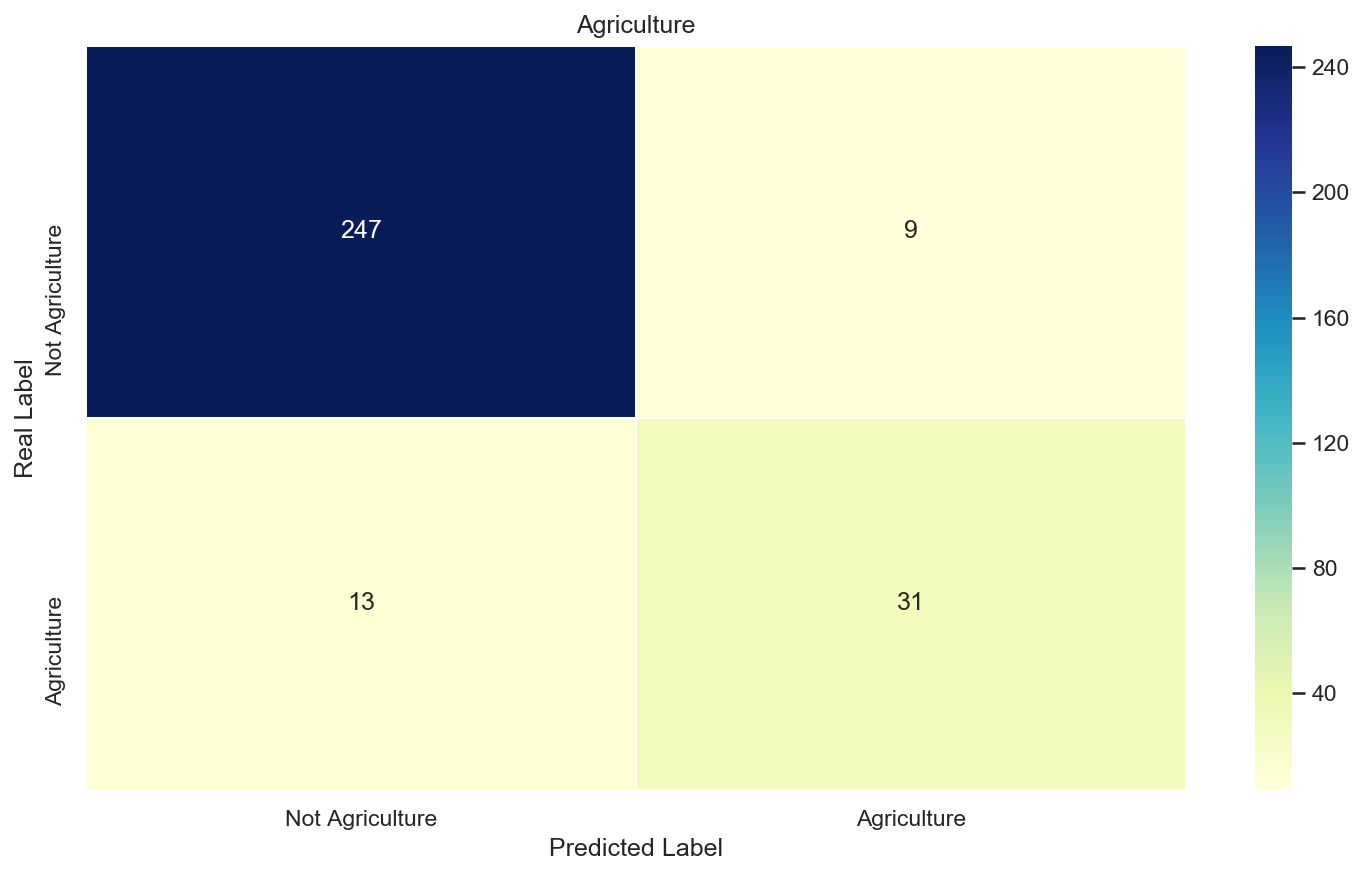

In [16]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pylab as plt
from study_design_type.study_type_labels import StudyTypeLabels

data_results = [([[247, 9],
                 [13, 31]],"Agriculture")]

for res in data_results:
    plt.figure(figsize=(10, 6), dpi=150)
    confusion_df = pd.DataFrame(res[0])
    confusion_df.index = ["Not Agriculture", "Agriculture"]
    confusion_df.columns = ["Not Agriculture", "Agriculture"]
    ax = sns.heatmap(confusion_df,annot=True, fmt="d",linewidths=.5,cmap="YlGnBu")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("Real Label")
    ax.set_title(res[1])
    plt.tight_layout()
    #plt.savefig(res[1] + "_study_type.png")
    plt.show()

In [15]:
print(get_accuracy_multi_label(test_labels, [deduplicated2labels[normalize_full(test_copy["Narrow concept"].values[i])] for i in range(len(test_data))]))

0.8170563961485557


In [5]:
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_usaid",
                                                                 label_non_intervention=5, class_weights="balanced")
intervention_labeler.load_previous_models("../model/usaid_interventions")

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Google word2vec loaded
Fast text loaded
Phrases loaded
Loaded vectorizer
Loaded nmf
Tf topics
P topic
P topic components
noun phrases


In [42]:
os.makedirs("../tmp/usaid_interv_additional_labeled", exist_ok=True)
all_df = pd.DataFrame()
for file in ["usaid_labelled_part.xlsx"]:
    df = excel_reader.ExcelReader().read_df_from_excel(file)
    df_pred = intervention_labeler.predict_class(df.values)
    df["Label"] = [USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label] for label in df_pred]
    all_df = pd.concat([all_df, df],axis=0)
excel_writer.ExcelWriter().save_df_in_excel(all_df, os.path.join("../tmp/usaid_interv_additional_labeled", "labeled.xlsx"), column_interventions=['Label'],
                                           dict_with_colors=USAIDInterventionLabels.INTERVENTION_LABELS_COLOR)

Read file usaid_labelled_part.xlsx: 0.04s
Processed file usaid_labelled_part.xlsx: 0.02s
Saving...
Saved to ../tmp/usaid_interv_additional_labeled\labeled.xlsx


../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


In [ ]:
df_1 = excel_reader.ExcelReader().read_df_from_excel("../tmp/usaid_interv_additional_labeled/labeled.xlsx")
sentences = {}
label_column = "Label"
for i in range(len(df_1)):
    if df_1["Sentence"].values[i] not in sentences:
        sentences[df_1["Sentence"].values[i]] = {}
    if df_1[label_column].values[i] != "Non-intervention":
        if df_1[label_column].values[i] not in sentences[df_1["Sentence"].values[i]]:
            sentences[df_1["Sentence"].values[i]][df_1[label_column].values[i]] = set()
        sentences[df_1["Sentence"].values[i]][df_1[label_column].values[i]].add(df_1["Narrow concept"].values[i].strip())
columns = ["Sanitation/Hygiene", "Water quality/Human health", "Water infrastructure", "Sustainability/Environmental health",
           "Community and behavior", "Assessment tool or program", "Policy"]
data_to_save = []
for sentence in sentences:
    data_point = [sentence]
    for column in columns:
        if column in sentences[sentence]:
            data_point.append(";".join(sentences[sentence][column]))
        else:
            data_point.append("")
    data_to_save.append(data_point)
excel_writer.ExcelWriter().save_data_in_excel(data_to_save, ["Sentence"] + columns, "mary_labelled_usaid_2.xlsx")

# DAC training

In [1]:
import pandas as pd
import gensim
import os
import numpy as np

import sys
sys.path.append('../src')
from interventions_labeling_lib import intervention_labeling
from interventions_labeling_lib.dac_intervention_labels import DacInterventionLabels

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
interventions_df = pd.read_excel('../data/DAC_train.xlsx').fillna("")

for i in range(len(interventions_df)):
    interventions_df["Label"].values[i] = DacInterventionLabels.INTERVENTION_LABEL_TO_NUMBER[interventions_df["Label"].values[i].strip()]
    
sorted(interventions_df.columns)

['Broad concepts',
 'Is abbreviation',
 'Label',
 'Narrow concept',
 'Words count',
 'broad concept and narrow concept occured together in articles',
 'common topic frequency',
 'narrow concept mentioned in articles',
 'our dataset word weight']

In [9]:
interventions_df["Label"].value_counts()

In [11]:
from sklearn.model_selection import train_test_split

def get_train_and_test_data_splitted(all_dataset = True, test_size=0.1):
    if all_dataset:
        train_data = interventions_df.values
        test_data = interventions_df.values
    else:
        train_data_x, test_data_x,train_y,test_y = train_test_split([data[:-1] for data in interventions_df.values], [data[-1] for data in interventions_df.values], test_size=test_size)
        train_data = np.concatenate((train_data_x,[[val]for val in train_y]),axis=1)
        test_data = np.concatenate((test_data_x,[[val] for val in test_y]),axis=1)
    return train_data, test_data

In [5]:
from importlib import reload
intervention_labeling = reload(intervention_labeling)

In [6]:
intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_retrained_new",
                                                                 label_non_intervention=31, class_weights={})
train_data,test_data = get_train_and_test_data_splitted(False)
intervention_labeler.train_model(train_data,test_data)

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator NMF from version 0.20.3 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarnin

SVM model whole embeddings


C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0

[0.54264841 0.54095623 0.53489327 0.52231838 0.58594401 0.56960917
 0.53018478 0.46421714 0.54667026 0.55334235]
Cross validation score(F1): 0.539078
Test accuracy : 0.745283
[[13  0  0  0  0  0  0  0  0  0  3  0  1  1  0  0  0  0  0  0  0  0  0  0
   1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  1]
 [ 0  0  5  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 1  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 2  0  0  0  0  0  4  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  2]
 [ 0  0  0  0  0  2  0 11  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  1
   2  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-

[0.29563957 0.31874399 0.28834525 0.32886893 0.28154585 0.29619215
 0.31458419 0.31966707 0.26382889 0.32090454]
Cross validation score(F1): 0.302832
Test accuracy : 0.430818
[[ 8  0  0  0  0  0  0  0  0  0  3  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  1]
 [ 0  0  0  5  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  7]
 [ 0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  6]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  3]
 [ 0  0  0  0  0  0  2  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  4]
 [ 0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0 14]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-

[0.54401704 0.56979257 0.59008311 0.5923494  0.55433885 0.66234844
 0.54597429 0.54245301 0.5909359  0.61372245]
Cross validation score(F1): 0.580602
Test accuracy : 0.735849
0.8768800279818119
[[14  0  0  0  0  0  0  0  0  0  2  0  1  1  0  0  0  0  0  0  0  0  0  0
   1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  1]
 [ 0  0  4  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 1  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 2  0  0  0  0  0  4  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  2]
 [ 0  0  0  0  0  1  0 13  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  1
   2  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0

[0.54883835 0.50084621 0.58382942 0.64860273 0.5170687  0.63028616
 0.54986134 0.43827758 0.55021071 0.56131854]
Cross validation score(F1): 0.552914
[[ 9  1  0  0  0  0  0  1  0  2  1  0  2  1  0  0  0  0  0  0  0  0  1  0
   0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  3  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 1  0  0 10  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 1  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  1]
 [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 1  0  0  0  0  0  5  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  1]
 [ 2  0  0  0  0  3  0  9  0  1  0  2  1  0  0  0  1  0  0  0  0  0  0  1
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0

[0.82084021 0.80782902 0.91014947 0.8537436  0.85316362 0.86716747
 0.84291568 0.7380672  0.79928337 0.7098765 ]
Cross validation score(F1): 0.820304
[[12  0  0  0  0  0  0  0  0  0  3  0  1  1  0  0  0  0  0  0  0  0  1  0
   0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  3  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0 10  0  0  1  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 2  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 1  0  0  0  0  0  5  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  1]
 [ 0  0  0  0  0  3  0 12  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0

[0.91677896 0.82412483 0.91491771 0.89362658 0.88686084 0.86841448
 0.84952802 0.86324336 0.81768092 0.67397052]
Cross validation score(F1): 0.850915
[[12  0  0  0  0  0  0  0  0  0  2  0  1  2  0  0  0  0  0  0  0  0  1  0
   0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  4  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0 10  0  0  1  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 2  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 1  0  0  0  0  0  5  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  1]
 [ 0  0  0  0  0  3  0 12  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [7]:
intervention_labeler.save_model("..\\model\\Dac_labelling")

In [1]:
import pandas as pd
import gensim
import os
import numpy as np

import sys
sys.path.append('../src')
from utilities import excel_writer
from interventions_labeling_lib import intervention_labeling
from interventions_labeling_lib.dac_intervention_labels import DacInterventionLabels

def predict_interventions(folder_to_check = "..\\notebooks\\interventions_to_check", folder_to_write = "..\\data\\interventions_1"):
    if not os.path.exists(folder_to_write):
        os.makedirs(folder_to_write)
    excelWriter = excel_writer.ExcelWriter()
    intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_retrained_new",
                                                                 label_non_intervention=31, class_weights={})
    intervention_labeler.load_previous_models("..\\model\\Dac_labelling")
    interventions_df_all = pd.DataFrame()
    for filename in os.listdir(folder_to_check):
        if os.path.isdir(os.path.join(folder_to_check, filename)):
            continue
        interventions_df = pd.read_excel(os.path.join(folder_to_check, filename)).fillna("")
        interventions_df["Predicted Label"] = [DacInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label] for label in intervention_labeler.predict_class(interventions_df.values)]
        interventions_df_all = pd.concat([interventions_df_all, interventions_df], axis=0,sort=False)
    excelWriter.save_df_in_excel(interventions_df_all, os.path.join(folder_to_write, "all_interventions_with_predicted_labels.xlsx"),column_interventions=['Label',"Predicted Label"], column_probabilities=['narrow concept mentioned in articles',
               'broad concept and narrow concept occured together in articles',
               'common topic frequency', 'our dataset word weight'],column_outliers=[("Words count", 1),("Is abbreviation", 1)], dict_with_colors=DacInterventionLabels.INTERVENTION_LABELS_COLOR)

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
predict_interventions("folder_with_interventions/interventions", "folder_with_interventions/DAC_interventions")

C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator NMF from version 0.20.3 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Maryia_Ivanina\AppData\Local\Continuum\anaconda3\envs\cornell\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarnin

L2C is not found (L2C research program)
L2C is not found (L2C research program;L2C research program;L2C project)
L2C is not found (L2C project)
L2C is not found (L2C project;L2C research program;L2C project)
L2C is not found (L2C research program)
L2C is not found (L2C research program;L2C research program;L2C project)
L2C is not found (L2C research program)
L2C is not found (L2C project)
L2C is not found (L2C project;L2C research program;L2C project)
L2C is not found (L2C project)
L2C is not found (L2C research program)
L2C is not found (L2C project)
EX3B is not found (aqueous solution;investigated using batch adsorption technique;investigated using astom acilyzer EX3B model ED device effective dos;major P adsorption mechanism;assessed using batch adsorption technique APU)
KX is not found (kaixin KX)
KX is not found (kaixin KX;right lateral recumbency using portable ultrasound machine)
EX3B is not found (aqueous solution;investigated using batch adsorption technique;investigated using

In [ ]:
from utilities import excel_reader
all_df = excel_reader.ExcelReader().read_df_from_excel("folder_with_interventions/DAC_interventions/all_interventions_with_predicted_labels.xlsx")
train_data_df = excel_reader.ExcelReader().read_df_from_excel("../data/DAC_train.xlsx")
all_interv = excel_reader.ExcelReader().read_df_from_excel("interventions.xlsx")
train_df_dict = {}
for i in range(len(train_data_df)):
    nar_con = train_data_df['Narrow concept'].values[i].strip()
    broad_con = train_data_df['Broad concepts'].values[i].strip()
    if (nar_con, broad_con) not in train_df_dict:
        train_df_dict[(nar_con, broad_con)] = train_data_df['Label'].values[i].strip()
all_df["Is used for training"] = ""
for i in range(len(all_df)):
    nar_con = all_df['Narrow concept'].values[i].strip()
    broad_con = all_df['Broad concepts'].values[i].strip()
    if (nar_con, broad_con) in train_df_dict:
        all_df["Is used for training"].values[i] = train_df_dict[(nar_con, broad_con)]

In [20]:
interventions_set = {}
for i in range(len(all_interv)):
    name = all_interv["Narrow concept"].values[i].strip() + " # " + all_interv["Abbreviation meaning"].values[i].strip()
    interventions_set[name] = (all_interv["Intervention class"].values[i].strip(), all_interv["Middle Layer names"].values[i].strip())

In [21]:
all_df["Intervention class"] = "Non-intervention"
all_df["Middle layer names"] = ""
for i in range(len(all_df)):
    name = all_df["Narrow concept"].values[i].strip()
    if name in interventions_set:
        all_df["Intervention class"].values[i] = interventions_set[name][0]
        all_df["Middle layer names"].values[i] = interventions_set[name][1]

In [22]:
from utilities import excel_writer
from interventions_labeling_lib.dac_intervention_labels import DacInterventionLabels
excel_writer.ExcelWriter().save_df_in_excel(all_df, os.path.join("all_interventions_with_predicted_labels.xlsx"),column_interventions=['Label',"Predicted Label", "Is used for training"], column_probabilities=['narrow concept mentioned in articles',
               'broad concept and narrow concept occured together in articles',
               'common topic frequency', 'our dataset word weight'],column_outliers=[("Words count", 1),("Is abbreviation", 1)], dict_with_colors=DacInterventionLabels.INTERVENTION_LABELS_COLOR)

Saving...
Saved to all_interventions_with_predicted_labels.xlsx


# t-SNE

In [41]:
from sklearn.manifold import TSNE
from matplotlib import pylab 
from sklearn.utils import shuffle
#intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder = "..\\model\\synonyms_retrained_new",
#                                                                  topics_folder="../model/nmf_3grams_all_reweight_125")
#intervention_labeler.load_previous_models("..\\model\\intervention_labels_model")
test_data = pd.DataFrame()
#interventions_df = shuffle(interventions_df)
for i in range(1,7):
    test_data = pd.concat([test_data, interventions_df[interventions_df["Label"] == i][:8]], axis=0)
data_to_check = intervention_labeler.get_data_before_predict(np.asarray(test_data.values))
#train_data,test_data = get_train_and_test_data_splitted(False,test_size = 0.03)
#data_to_check = intervention_labeler.get_data_before_predict(test_data)

tsne = TSNE(perplexity=20, n_components=2, init='pca', n_iter=5000, method='exact') 
two_d_data = tsne.fit_transform(data_to_check)
labels_pred = np.asarray([d[-1] for d in test_data.values])#intervention_labeler.predict_class(test_data)
 
color_dict = {1:'#0000ff', 2:'#c71585',3: '#20b2aa',4:'#663399', 5: "#006400", 6: "#ffd700", }
labels_dict = {1:'Technology intervention', 2:'Socioeconomic intervention',3: 'Ecosystem intervention',4:"Storage intervention", 5:'Mechanisation intervention', 6:"Non intervention"}

def plot(embeddings, labels): 
    pylab.figure(figsize=(60,40), dpi=200) # in inches 
    x, y = np.asarray([embeddings[i,0] for i in range(len(embeddings))]),np.asarray([embeddings[i,1] for i in range(len(embeddings))])
    for g in range(1,7): 
        i = np.where(labels_pred == g)
        pylab.scatter(x[i], y[i], c=color_dict[g], label=labels_dict[g], s=1000) 
    for i,label in enumerate(test_data["Narrow concept"].values): 
        x, y = embeddings[i,:] 
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom',size=50)
    pylab.tight_layout()
    pylab.legend(prop={'size': 40})
    # Hide the right and top spines
    pylab.axis("off")
    pylab.savefig('300pointsTSNE.png')
    pylab.show()

plot(two_d_data, [label[0] for label in test_data])

In [17]:
from sklearn.manifold import TSNE
from matplotlib import pylab 

intervention_labeler = intervention_labeling.InterventionLabeling()
intervention_labeler.load_previous_models("..\\model\\intervention_labels_model")
train_data,test_data = get_train_and_test_data_splitted(False,test_size = 0.15)
data_to_check = intervention_labeler.get_data_before_predict(test_data)

tsne = TSNE(perplexity=20, n_components=2, init='pca', n_iter=5000, method='exact') 
two_d_data = tsne.fit_transform(data_to_check)
labels_pred = np.asarray([d[-1] for d in test_data])#intervention_labeler.predict_class(test_data)
 
color_dict = {1:'#0000ff', 2:'#c71585',3: '#20b2aa',4:'#663399', 5: "#006400", 6: "#ffd700", }
labels_dict = {1:'Technology intervention', 2:'Socioeconomic intervention',3: 'Ecosystem intervention',4:"Storage intervention", 5:'Mechanisation intervention', 6:"Non intervention"}

def plot(embeddings, labels): 
    pylab.figure(figsize=(40,30)) # in inches 
    x, y = np.asarray([embeddings[i,0] for i in range(len(embeddings))]),np.asarray([embeddings[i,1] for i in range(len(embeddings))])
    for g in range(1,7): 
        i = np.where(labels_pred == g)
        pylab.scatter(x[i], y[i], c=color_dict[g], label=labels_dict[g], s=100) 
    for i,label in enumerate(labels): 
        x, y = embeddings[i,:] 
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom',size=20)
    pylab.tight_layout()
    pylab.legend(prop={'size': 40})
    #pylab.savefig('300pointsTSNE.png') 
    pylab.show() 

plot(two_d_data, [label[0] for label in test_data])

../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]
../src\interventions_labeling_lib\intervention_labeling.py:172: RuntimeWarning: invalid value encountered in true_divide
  res = x / np.sum(x, axis=1)[:, None]


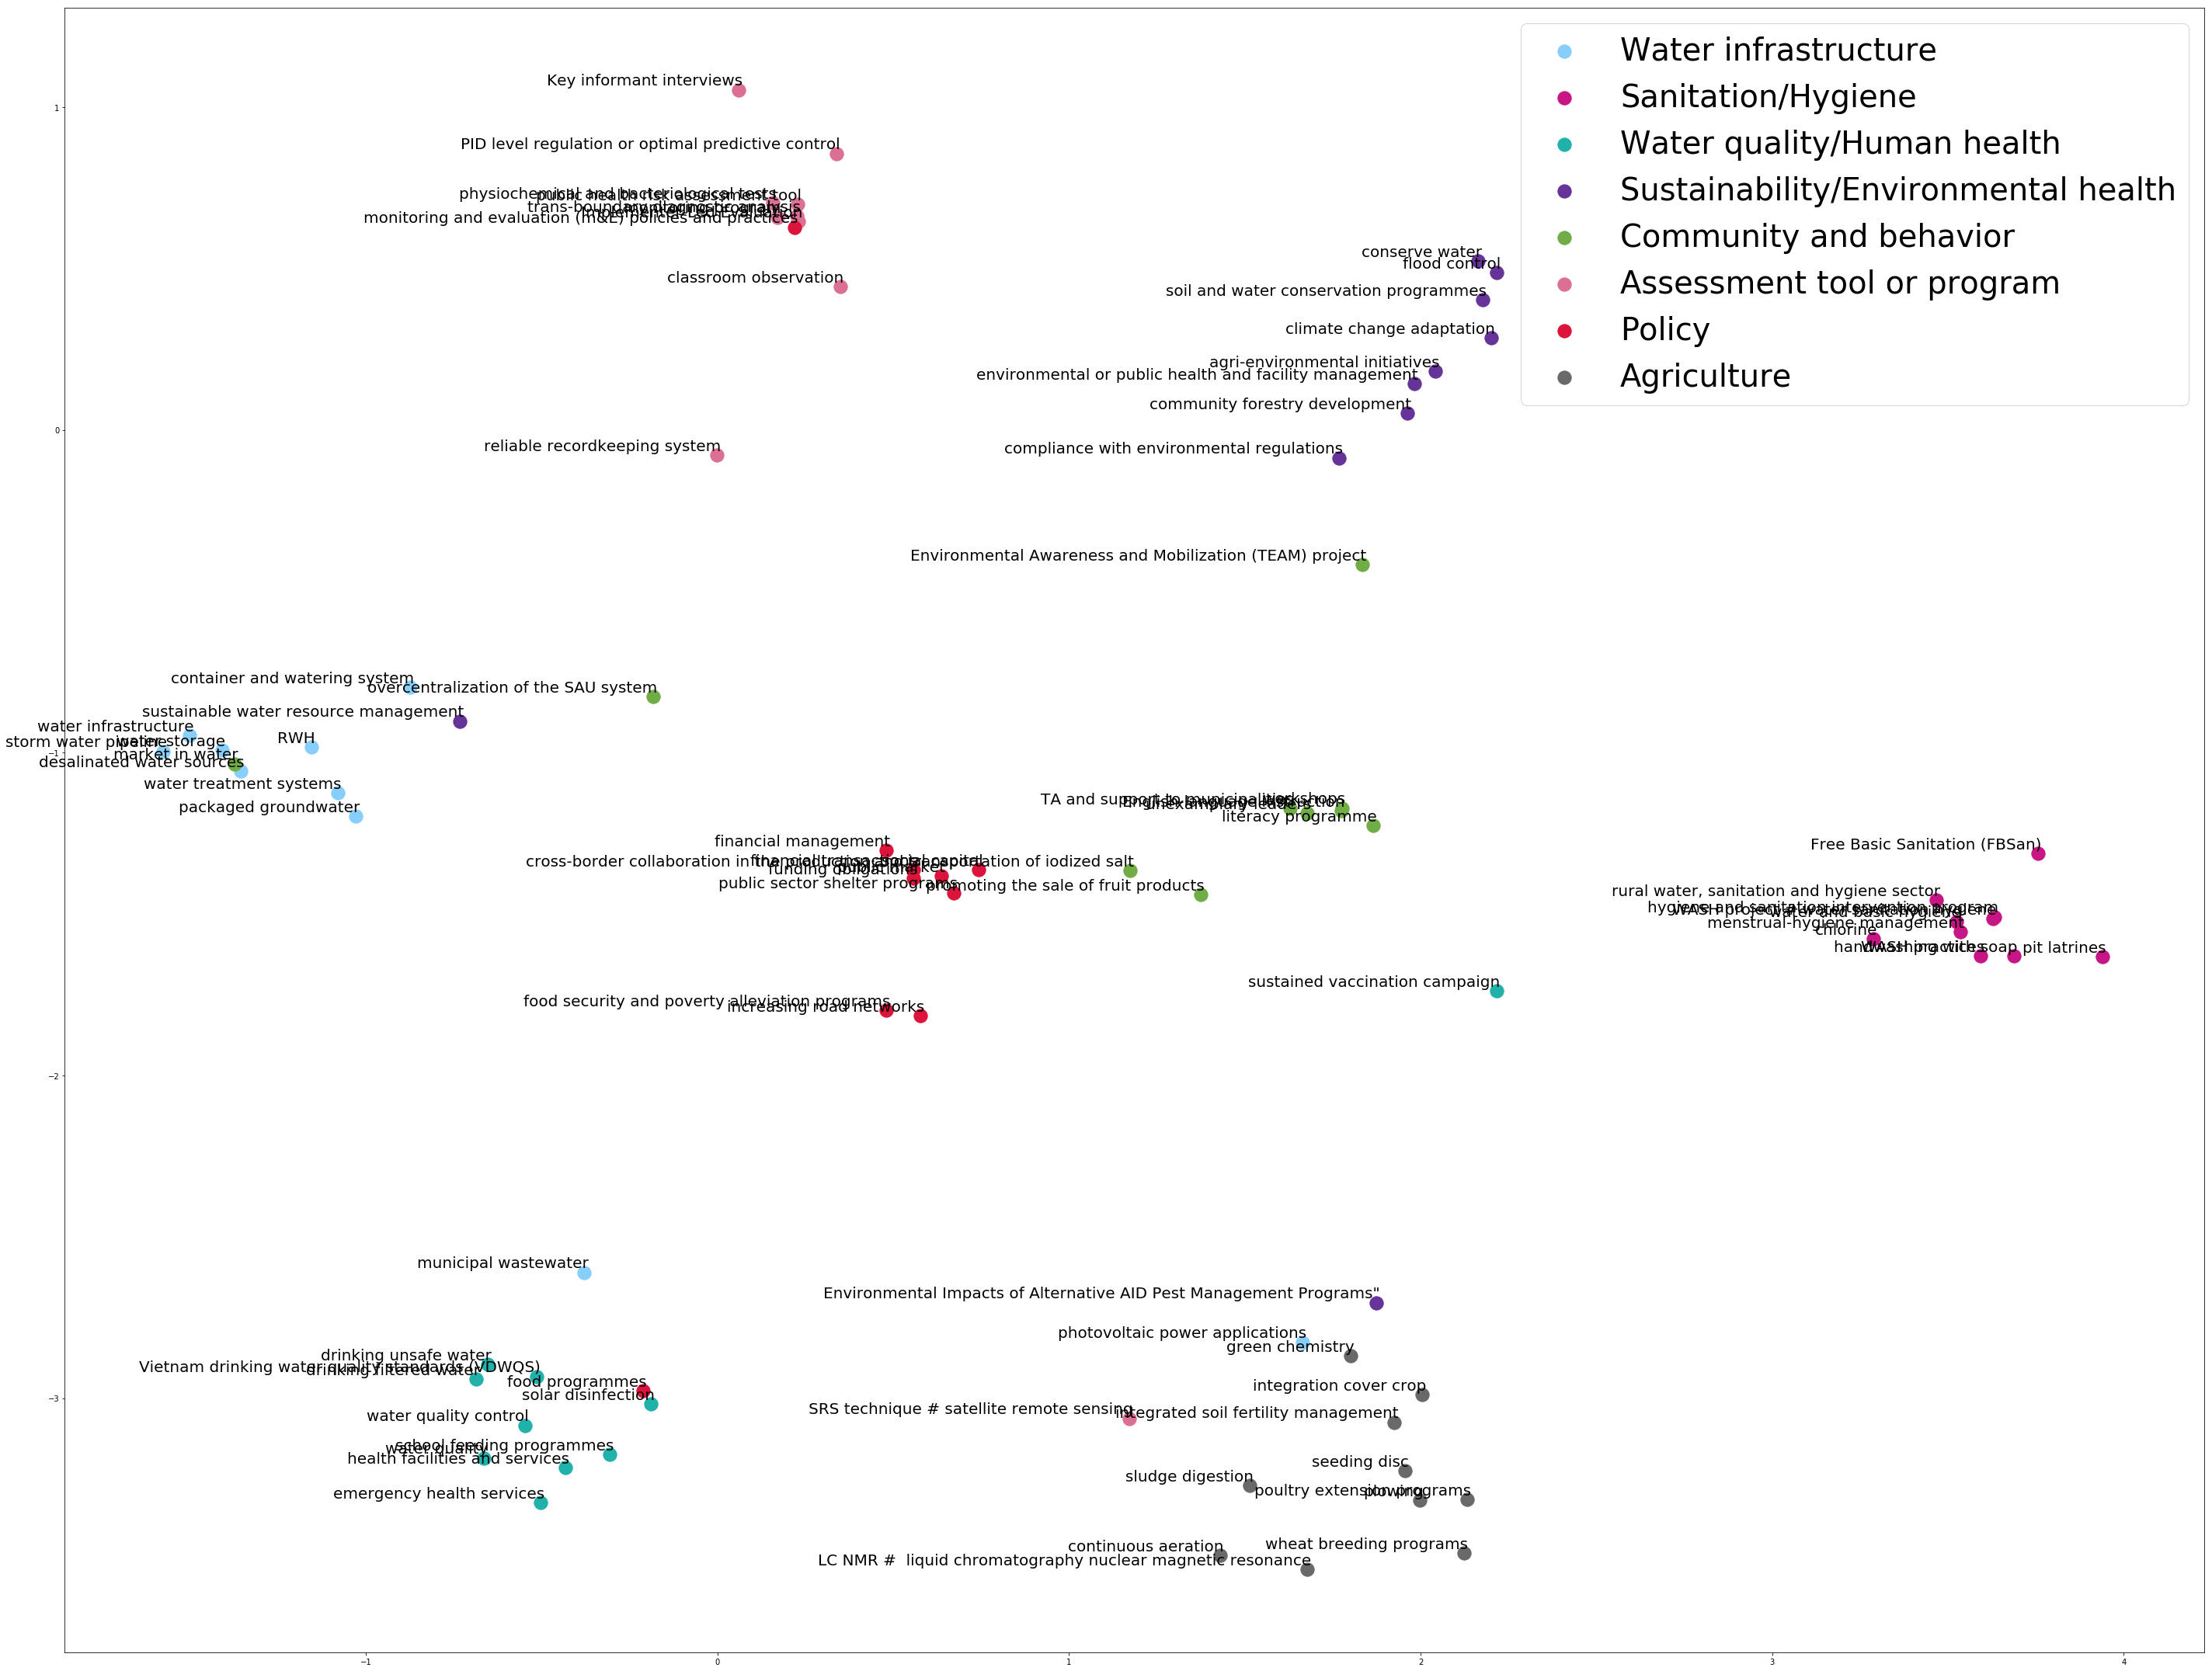

In [16]:
from sklearn.manifold import TSNE
from matplotlib import pylab
from interventions_labeling_lib.usaid_intervention_labels import USAIDInterventionLabels
from interventions_labeling_lib import intervention_labeling
intervention_labeling = reload(intervention_labeling)

intervention_labeler = intervention_labeling.InterventionLabeling(google_models_folder="../model/synonyms_retrained_new",
                                                                 label_non_intervention=9, class_weights={1:2, 2:2, 3:2, 4:2, 5:2, 6:2, 7:2, 8:2, 9:1})
intervention_labeler.load_previous_models("../model/usaid_interventions_new")

embed_data = []
names = []
data_labels = []
for label in usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL:
    if label != 9:
        part_data = shuffle(train_df[train_df["Label"] == label])[:10]
        names.extend(list(part_data["Narrow concept"].values))
        df_pred = intervention_labeler.get_data_before_predict(part_data.values).tolist()
        embed_data.extend(df_pred)
        data_labels.extend([label for i in range(len(part_data))])

tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=10000, method='exact') 
two_d_data = tsne.fit_transform(embed_data)
labels_pred = np.asarray(data_labels)

color_dict = {}
for label in usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL:
    color_dict[label] = usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_LABELS_COLOR[usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL[label]][0]
labels_dict = usaid_intervention_labels.USAIDInterventionLabels.INTERVENTION_NUMBER_TO_LABEL

def plot(embeddings, labels): 
    pylab.figure(figsize=(40,30)) # in inches 
    x, y = np.asarray([embeddings[i,0] for i in range(len(embeddings))]),np.asarray([embeddings[i,1] for i in range(len(embeddings))])
    for g in range(1,9): 
        i = np.where(labels_pred == g)
        pylab.scatter(x[i], y[i], c=color_dict[g], label=labels_dict[g], s=300) 
    for i,label in enumerate(labels): 
        x, y = embeddings[i,:] 
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom',size=20)
    pylab.tight_layout()
    pylab.legend(prop={'size': 40})
    pylab.savefig('Usaid_pointsTSNE.png') 
    pylab.show() 

plot(two_d_data, names)